В этом ноутбуке я буду работать с датасетом, содержащим информацию о квартирах, и проводить его детальный анализ. Цель —  изучить свойства данных и выявить ключевые закономерности и применить методы ML для построения модели, которая сможет прогнозировать стоимость квартир на основе их входных параметров.

Основные задачи ноутбука:

Знакомство с данными: Ознакомимся с датасетом, изучим его структуру, содержание и основные параметры.

Предобработка и очистка данных: Устраним пропущенные значения, выбросы в данных.

Исследовательский анализ данных: С помощью визуализаций и статистического анализа выявим основные закономерности и взаимосвязи между стоимостью и характеристиками квартир.

Моделирование с использованием ML: Построим и оценим модели машинного обучения для прогнозирования стоимости квартир:

Подготовим данные для обучения (нормализация, выделение признаков, разбиение на обучающую и тестовую выборки).

Выводы и рекомендации: Подведем итоги анализа и прогнозирования, и сделаем выводами.

Что будем изучать и прогнозировать:
Какие факторы наиболее сильно влияют на стоимость квартиры?
Как распределяются цены в зависимости от различных характеристик?
Насколько точно модели машинного обучения смогут предсказать цену квартиры?
Какие признаки оказывают наибольшее влияние на прогнозирование?
Используемый инструментарий:
Для выполнения анализа и построения моделей мы будем использовать следующие библиотеки:

///


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import lightgbm as lgb
from lightgbm import LGBMRegressor
import geopandas as gpd
from shapely.geometry import Point
import warnings
import optuna



warnings.filterwarnings('ignore')

os.environ["LOKY_MAX_CPU_COUNT"] = "4"  
os.environ["OMP_NUM_THREADS"] = "1"  # Ограничиваем количество потоков


pd.set_option('display.max_columns', None)
df = pd.read_csv(r'C:\Users\spot2\OneDrive\Рабочий стол\Скрипты\flats.xlsx - Лист1.csv')
df['lat'] = df['lat'].str.replace(',', '.').astype(float)
df['lon'] = df['lon'].str.replace(',', '.').astype(float)
df['area'] = df['area'].str.replace(',', '.').astype(float)
df['kitchen_area'] = df['kitchen_area'].astype(str).str.replace(',', '.').astype(float)
df = df.dropna(subset=['price_sq'])

Прежде чем начнём анализ, напишем функции для того чтобы не дублировать код и сократить notebook 

In [107]:
def plot_price_by_categories(
    df,
    cat_col1,
    cat_col2,
    price_col,
    title1,
    xlabel1,
    title2,
    xlabel2,
    ylabel='Цена',
    palette='Set1'
):
    """
    Создает два boxplot графика для сравнения распределения цен в зависимости
    от значений двух категориальных признаков.

    Args:
        df (pd.DataFrame): Исходный DataFrame с данными.
        cat_col1 (str): Название колонки с первым категориальным признаком.
        cat_col2 (str): Название колонки со вторым категориальным признаком.
        price_col (str): Название колонки с ценой.
        title1 (str): Заголовок для первого графика.
        xlabel1 (str): Подпись оси X для первого графика.
        title2 (str): Заголовок для второго графика.
        xlabel2 (str): Подпись оси X для второго графика.
        ylabel (str, optional): Подпись оси Y для обоих графиков. Defaults to 'Цена'.
        palette (str, optional): Цветовая палитра для графиков seaborn. Defaults to 'Set1'.
    """
    # Убираем строки с NaN в ключевых колонках
    filtered_df = df.dropna(subset=[
        cat_col1,
        cat_col2,
        price_col
    ])

    # Определяем порядок категорий 
    categories_order = filtered_df[cat_col1].unique()

    # Увеличиваем размер фигуры, чтобы два графика поместились
    plt.figure(figsize=(16, 6))

    # Левый график
    plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
    sns.boxplot(
        data=filtered_df,
        x=cat_col1,
        y=price_col,
        palette=palette,
        order=categories_order  # Указываем порядок категорий
    )
    plt.title(title1, fontsize=16)
    plt.xlabel(xlabel1, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)  # Поворот подписей

    # Правый график
    plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
    sns.boxplot(
        data=filtered_df,
        x=cat_col2,
        y=price_col,
        palette=palette,
        order=categories_order  # Указываем тот же порядок категорий
    )
    plt.title(title2, fontsize=16)
    plt.xlabel(xlabel2, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)  # Поворот подписей

    # Отображаем графики
    plt.tight_layout()  # Устраняем наложение элементов
    plt.show()
    
    
def kruskal_wallis_test(df, categorical_col):
    """
    Выполняет тест Краскела-Уоллиса для сравнения распределений 'price_sq' по группам, заданным категориальным столбцом.
    
    Args:
    df (pd.DataFrame): Исходный DataFrame.
    categorical_col (str): Название категориального столбца для группировки.
    
    Returns:
    tuple: (statistic, p_value) - статистика теста и p-значение.
    """
    # Удаляем строки с NaN в ключевом столбце
    filtered_df = df.dropna(subset=[categorical_col])
    
    # Формируем группы для теста
    groups = [
        filtered_df[filtered_df[categorical_col] == category]['price_sq'].values
        for category in filtered_df[categorical_col].unique()
    ]
    
    # Проводим тест Краскела-Уоллиса
    statistic, p_value = stats.kruskal(*groups)
    
    return statistic, p_value
    
    
    
def plot_price_by_category(
    df,
    cat_col,
    price_col,
    title,
    xlabel,
    ylabel='Цена',
    palette='Set1'
):
    """
    Создает boxplot график для сравнения распределения цен в зависимости
    от значений заданного категориального признака.

    Args:
        df (pd.DataFrame): Исходный DataFrame с данными.
        cat_col (str): Название колонки с категориальным признаком.
        price_col (str): Название колонки с ценой.
        title (str): Заголовок графика.
        xlabel (str): Подпись оси X.
        ylabel (str, optional): Подпись оси Y. Defaults to 'Цена'.
        palette (str, optional): Цветовая палитра для графика seaborn. Defaults to 'Set1'.
    """
    # Убираем строки с NaN в ключевых колонках
    filtered_df = df.dropna(subset=[
        cat_col,
        price_col
    ])

    # Определяем порядок категорий (можно взять уникальные значения из категориальной колонки)
    categories_order = filtered_df[cat_col].unique()

    # Увеличиваем размер фигуры
    plt.figure(figsize=(8, 6))  # Уменьшил размер, так как график один

    # Создаем boxplot
    sns.boxplot(
        data=filtered_df,
        x=cat_col,
        y=price_col,
        palette=palette,
        order=categories_order  # Указываем порядок категорий
    )
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)  # Поворот подписей

    # Отображаем график
    plt.tight_layout()  # Устраняем наложение элементов
    plt.show()

def train_evaluate_model(
    df,
    features,
    target,
    ml_method,
    metric_funcs,
    categorical_features=None,
    test_size=0.2,
    random_state=42,
    stratify_by_target=True,
    metric_averages=None
):
    """
    Обучает ML модель, делает предсказания и оценивает качество модели.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        features (list): Список названий признаков.
        target (str): Название целевой переменной.
        ml_method: Экземпляр ML модели (например, CatBoostClassifier(), RandomForestClassifier()).
        metric_funcs (list): Список функций для расчета метрик (например, [accuracy_score, f1_score]).
        categorical_features (list, optional): Список названий категориальных признаков. Defaults to None.
        test_size (float, optional): Размер тестовой выборки. Defaults to 0.2.
        random_state (int, optional): Random state для воспроизводимости. Defaults to 42.
        stratify_by_target (bool, optional): Стратифицировать ли разбиение на train/test по целевой переменной. Defaults to True.
        metric_averages (dict, optional): Словарь, где ключи - названия метрик ('f1_score', 'precision_score', 'recall_score'),
                                         а значения - метод усреднения (например, 'binary', 'weighted', 'macro').
                                         Defaults to None (без усреднения для f1, precision, recall).

    Returns:
        tuple: (обученная модель, предсказания на тестовой выборке, словарь с метриками)
    """

    # Разделение данных на признаки и целевую переменную
    X = df[features]
    y = df[target]

    # Кодируем целевую переменную
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Разделим данные на тренировочную и тестовую выборки
    stratify = y_encoded if stratify_by_target else None
    X_train, X_test, y_train, y_test_encoded = train_test_split(X, y_encoded, test_size=test_size, random_state=random_state, stratify=stratify)

    # Проверяем, является ли модель CatBoostClassifier и передаем категориальные признаки
    if isinstance(ml_method, CatBoostClassifier) and categorical_features:
        ml_method.set_params(cat_features=categorical_features)

    # Обучение модели
    ml_method.fit(X_train, y_train, verbose=False)  # Отключаем verbose по умолчанию

    # Предсказания модели
    y_pred_encoded = ml_method.predict(X_test)

    # Возвращаем предсказания и тестовые значения к исходным текстовым меткам
    y_test_labels = encoder.inverse_transform(y_test_encoded)
    y_pred_labels = encoder.inverse_transform(y_pred_encoded)

    print("Метрики качества модели:")
    metrics = {}
    for metric_func in metric_funcs:
        metric_name = metric_func.__name__
        if metric_name in ['f1_score', 'precision_score', 'recall_score']:
            average = metric_averages.get(metric_name) if metric_averages and metric_name in metric_averages else None
            metric_value = metric_func(y_test_encoded, y_pred_encoded, average=average)
        else:
            metric_value = metric_func(y_test_encoded, y_pred_encoded)
        print(f"{metric_name}: {metric_value:.4f}")
        metrics[metric_name] = metric_value

    # Построение матрицы ошибок
    cm = confusion_matrix(y_test_encoded, y_pred_encoded)

    # Преобразуем метки классов обратно в текстовые значения для удобства интерпретации
    class_names = encoder.inverse_transform(range(len(encoder.classes_)))

    # Визуализация матрицы ошибок
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    return ml_method, y_pred_labels, metrics
    
    
def fill_missing_with_model(df, model, features, target):
    """
    Заполняет пропущенные значения в целевой переменной DataFrame, используя обученную ML модель.

    Args:
        df (pd.DataFrame): DataFrame с пропущенными значениями.
        model: Обученная ML модель с методом predict.
        features (list): Список признаков, использованных при обучении модели.
        target (str): Название целевой переменной с пропущенными значениями.

    Returns:
        pd.DataFrame: DataFrame с заполненными пропущенными значениями в целевой переменной.
    """
    missing_data = df[df[target].isnull()].copy()
    if missing_data.empty:
        print(f"Нет пропущенных значений в колонке '{target}'.")
        return df

    X_missing = missing_data[features].copy()

    # Проверяем, был ли целевой столбец закодирован и есть ли атрибут encoder у модели
    encoder = None
    if hasattr(model, 'classes_'):  
        unique_target_values = df[target].dropna().unique()
        encoder = LabelEncoder().fit(unique_target_values)

    predicted_values_encoded = model.predict(X_missing)

    if encoder:
        predicted_values = encoder.inverse_transform(predicted_values_encoded)
    else:
        predicted_values = predicted_values_encoded

    missing_indices = missing_data.index
    df.loc[missing_indices, target] = predicted_values
    print(f"Пропущенные значения в колонке '{target}' успешно заполнены с помощью модели.")
    return df


def train_evaluate_regression_model(
    df,
    features,
    target,
    ml_method,
    metric_funcs,
    categorical_features=None,
    test_size=0.2,
    random_state=42
):
    """
    Обучает регрессионную ML модель, делает предсказания и оценивает качество модели.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        features (list): Список названий признаков.
        target (str): Название целевой переменной.
        ml_method: Экземпляр регрессионной ML модели (например, CatBoostRegressor(), LinearRegression()).
        metric_funcs (list): Список функций для расчета регрессионных метрик (например, [mean_absolute_error, r2_score]).
        categorical_features (list, optional): Список названий категориальных признаков. Defaults to None.
        test_size (float, optional): Размер тестовой выборки. Defaults to 0.2.
        random_state (int, optional): Random state для воспроизводимости. Defaults to 42.

    Returns:
        tuple: (обученная модель, предсказания на тестовой выборке, словарь с метриками)
    """

    # Разделение данных на признаки и целевую переменную
    X = df[features]
    y = df[target]

    # Разделим данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Проверяем, является ли модель CatBoostRegressor и передаем категориальные признаки
    if isinstance(ml_method, CatBoostRegressor) and categorical_features:
        ml_method.set_params(cat_features=categorical_features)

    # Обучение модели
    ml_method.fit(X_train, y_train, verbose=False)  # Отключаем verbose по умолчанию

    # Предсказания модели
    y_pred = ml_method.predict(X_test)

    print("Метрики качества модели регрессии:")
    metrics = {}
    for metric_func in metric_funcs:
        metric_name = metric_func.__name__
        if metric_name == 'mean_absolute_percentage_error':
            metric_value = metric_func(y_test, y_pred) * 100
        else:
            metric_value = metric_func(y_test, y_pred)
        print(f"{metric_name}: {metric_value:.3f}")
        metrics[metric_name] = metric_value

    # Рассчитываем RMSE отдельно
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"rmse: {rmse:.2f}")
    metrics['rmse'] = rmse

    return ml_method, y_pred, metrics



def fill_missing_regression(df, model, features, target):
    """
    Заполняет пропущенные значения в целевой переменной DataFrame, используя обученную регрессионную ML модель.

    Args:
        df (pd.DataFrame): DataFrame с пропущенными значениями.
        model: Обученная регрессионная ML модель с методом predict.
        features (list): Список признаков, использованных при обучении модели.
        target (str): Название целевой переменной с пропущенными значениями.

    Returns:
        pd.DataFrame: DataFrame с заполненными пропущенными значениями в целевой переменной.
    """
    missing_data = df[df[target].isna()].copy()
    if missing_data.empty:
        print(f"Нет пропущенных значений в колонке '{target}'.")
        return df

    X_missing = missing_data[features].copy()

    predicted_values = model.predict(X_missing).round()

    missing_indices = missing_data.index
    df.loc[missing_indices, target] = predicted_values
    print(f"Пропущенные значения в колонке '{target}' успешно заполнены с помощью модели.")
    return df

Проанализиируем целевую переменную price_sq. 

In [108]:
df['price_sq'].describe()

count      6690.000000
mean     194558.357250
std       83045.323878
min       21108.000000
25%      136289.500000
50%      179369.000000
75%      233314.750000
max      734693.000000
Name: price_sq, dtype: float64

Shapiro-Wilk Test для price_sq:
Статистика: 0.9185
P-значение: 0.0000


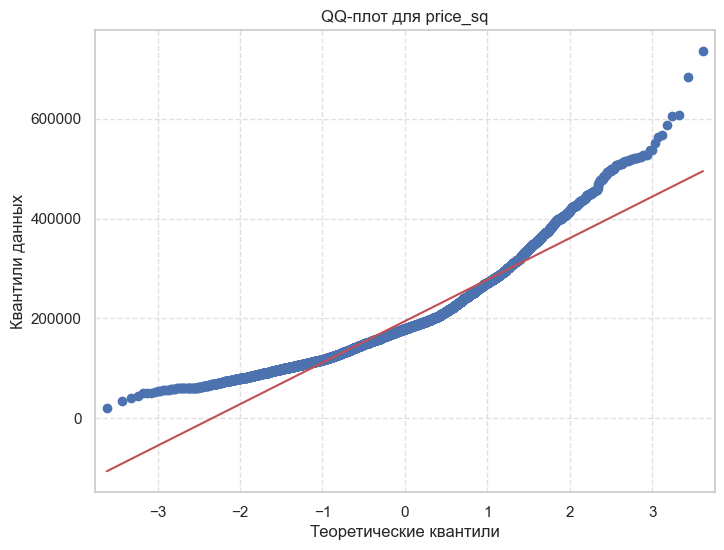

In [109]:
# Проверка нормальности для price_sq
shapiro_stat, shapiro_p = stats.shapiro(df['price_sq'].dropna())

print(f"Shapiro-Wilk Test для price_sq:")
print(f"Статистика: {shapiro_stat:.4f}")
print(f"P-значение: {shapiro_p:.4f}")

# Построение QQ-плота для price_sq
plt.figure(figsize=(8, 6))
sm.qqplot(df['price_sq'].dropna(), line='s', ax=plt.gca())
plt.title('QQ-плот для price_sq')
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили данных')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


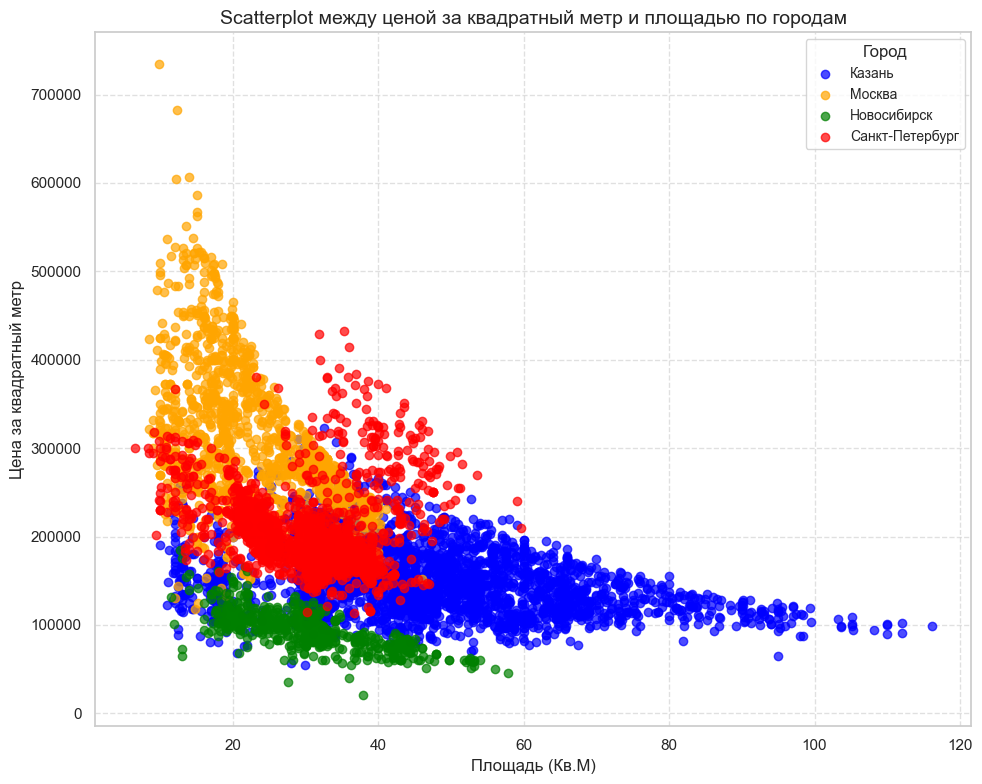

In [110]:
# Создание графика
plt.figure(figsize=(10, 8))  # Увеличим размер для лучшей читаемости

# Список выбранных городов и соответствующих цветов
selected_cities = ['Казань', 'Москва', 'Новосибирск', 'Санкт-Петербург']
colors = ['blue', 'orange', 'green', 'red']

# Фильтрация данных, чтобы исключить NaN в area и price_sq
valid_data = df.dropna(subset=['city', 'area', 'price_sq'])

# Построение scatterplot для каждого города
for city, color in zip(selected_cities, colors):
    city_data = valid_data[valid_data['city'] == city]
    if not city_data.empty:  # Проверка на наличие данных
        plt.scatter(city_data['area'], city_data['price_sq'], color=color, label=city, alpha=0.7)

# Настройки графика
plt.title('Scatterplot между ценой за квадратный метр и площадью по городам', fontsize=14)
plt.xlabel('Площадь (Кв.М)', fontsize=12)
plt.ylabel('Цена за квадратный метр', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Город', fontsize=10)  # Добавляем легенду
plt.tight_layout()  # Устраняем наложение элементов

# Показать график
plt.show()

Видно что по мере увеличиения квадртаных метров, цена за квадртаный метр имеет тенденцию на снижение или же другими словами: чем больше квадратных метров в квартире, тем меньше цена за квадртаный метр, она стремится к 100 тыс руб за Кв.М.

Посчитатаем корреляцию Спирмена.

In [111]:
# Расчет корреляции Спирмена
correlation, p_value = spearmanr(df['price_sq'], df['area'])

print(f"Корреляция Спирмена: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Корреляция Спирмена: -0.4956
P-value: 0.0000


Посмотрим гистограмму цены квартиры.

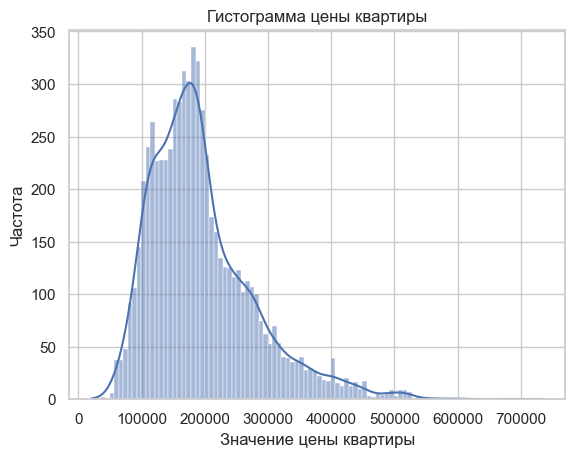

In [112]:
# Построение гистограммы с 100 bins
sns.histplot(df['price_sq'], bins=100, kde=True)
plt.title('Гистограмма цены квартиры')
plt.xlabel('Значение цены квартиры')
plt.ylabel('Частота')
plt.show()

Распределение будто бы бимодальное, попробую посмотреть из-за чего так может быть. 

In [113]:
# Функция для категоризации
def categorize_year(year):
    if year < 2000:
        return 'до 2000'
    else:
        return 'после 2000'

# Применение функции к столбцу build_year и создание нового столбца category
df['category'] = df['build_year'].apply(categorize_year)


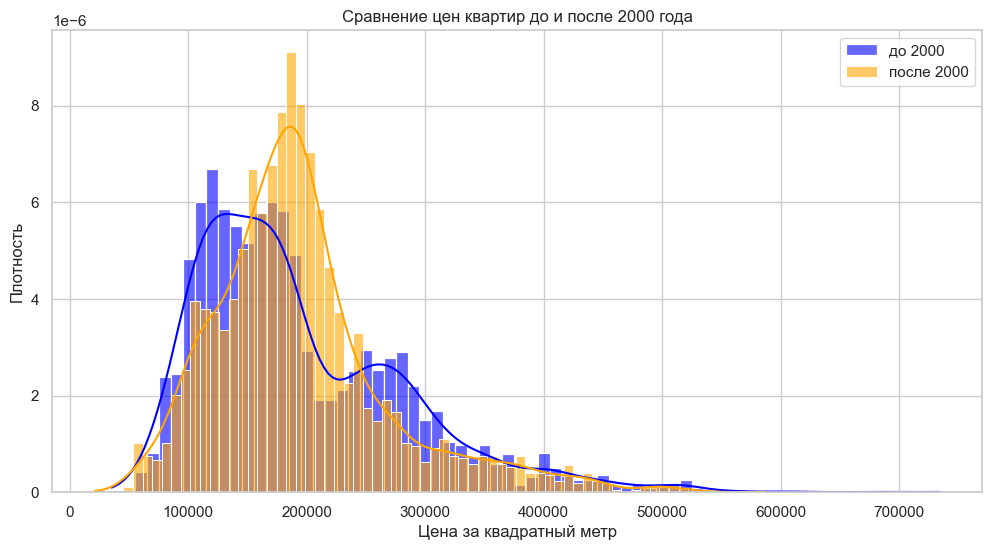

In [114]:
# Применение функции к столбцу build_year и создание нового столбца category
df['category'] = df['build_year'].apply(categorize_year)

# Установка стиля для графиков
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))

# Построение гистограммы для квартир до 2000 года
sns.histplot(df[df['category'] == 'до 2000']['price_sq'], bins=70, color='blue', label='до 2000', kde=True, stat='density', alpha=0.6)

# Построение гистограммы для квартир после 2000 года
sns.histplot(df[df['category'] == 'после 2000']['price_sq'], bins=70, color='orange', label='после 2000', kde=True, stat='density', alpha=0.6)

# Настройки графика
plt.title('Сравнение цен квартир до и после 2000 года')
plt.xlabel('Цена за квадратный метр')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

Выглядит теперь чуть получше, но в домах до 2000 дома все равно остается бимодальность.

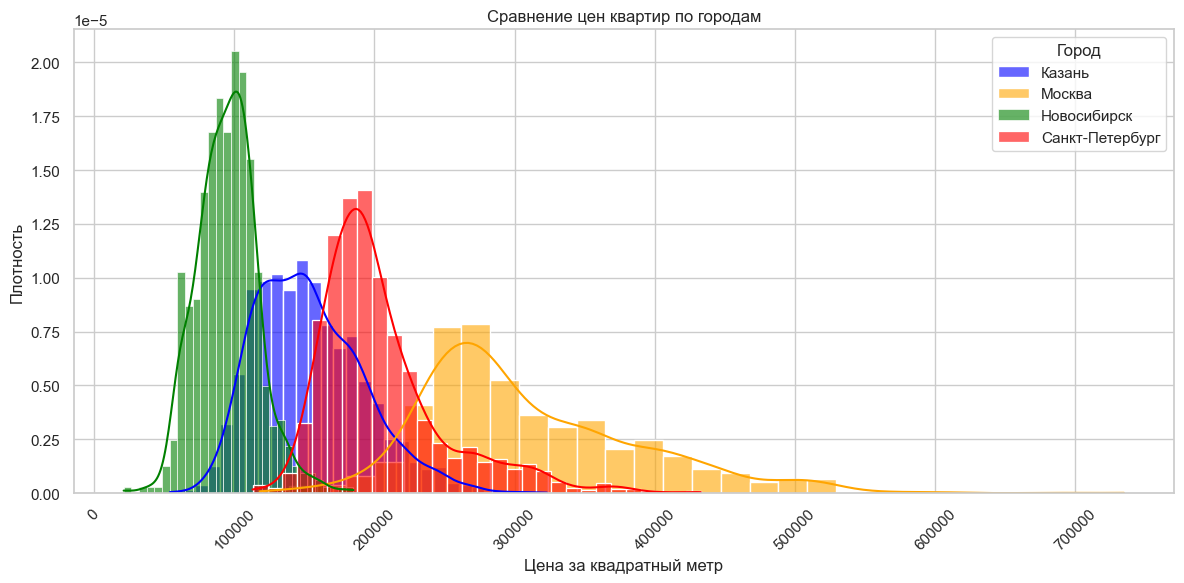

In [115]:
# Установка стиля для графиков
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))

# Фильтрация данных, чтобы исключить NaN в city и price_sq
valid_data = df.dropna(subset=['city', 'price_sq'])

# Список выбранных городов и соответствующих цветов
selected_cities = ['Казань', 'Москва', 'Новосибирск', 'Санкт-Петербург']
colors = ['blue', 'orange', 'green', 'red']

# Построение гистограмм для выбранных городов
for city, color in zip(selected_cities, colors):
    subset = valid_data[valid_data['city'] == city]
    if not subset.empty:  # Проверка на наличие данных
        sns.histplot(data=subset, x='price_sq', bins=30, color=color, label=city, 
                     kde=True, stat='density', alpha=0.6)

# Настройки графика
plt.title('Сравнение цен квартир по городам')
plt.xlabel('Цена за квадратный метр')
plt.ylabel('Плотность')
plt.legend(title='Город')
plt.grid(True)

# Показать график
plt.xticks(rotation=45)  # Поворот подписей городов для читаемости
plt.tight_layout()  # Устраняем наложение элементов
plt.show()

In [116]:
statistic, p_value = kruskal_wallis_test(df, 'city')

print(f"Kruskal-Wallis Test для price_sq по городам:")
print(f"Статистика: {statistic:.2f}")
print(f"P-значение: {p_value:.4f}")

Kruskal-Wallis Test для price_sq по городам:
Статистика: 4458.99
P-значение: 0.0000


Можно наблюдать что бимодальность также возникает из-за смешения рынков. В Москве и Санкт-Петербурге цены выше, что также создает бимодальность. Таким образом разные рынки и года постройки делают распределение ненормальным.

In [117]:
df

,id,offer_views,city,lat,lon,price_sq,area,floor,kitchen_area,bathroom_type,balconies,renovation,is_apartment,rooms,has_gas,house_floors,house_wall_type,lifts,freight_lifts,time_on_foot_to_subway,build_year,urgent,duplicates_count,sale_type,is_auction,all_data.house.ceiling_height,all_data.house.has_garbage_disposer,all_data.is_auction,all_data.object_info.living_area,all_data.object_info.window_view[0].display_name,all_data.object_info.window_view[1].display_name,all_data.object_info.window_view[2].display_name,all_data.object_info.window_view[3].display_name,all_data.object_info.window_view[4].display_name,all_data.object_info.loggias,all_data.legal_options.approve,all_data.legal_options.mortgage,all_data.legal_options.is_individual,all_data.legal_options.is_owner,all_data.legal_options.owner_minors,all_data.legal_options.residence_minors,all_data.object_info.redevelopment,all_data.house.security[0].display_name,all_data.house.security[1].display_name,all_data.house.security[2].display_name,all_data.house.security[3].display_name,all_data.house.parking[0].display_name,all_data.house.parking[1].display_name,all_data.house.parking[2].display_name,all_data.house.parking[3].display_name,all_data.house.parking[4].display_name,all_data.house.yard[0].display_name,all_data.house.yard[1].display_name,all_data.house.infrastructure[0].display_name,all_data.house.infrastructure[1].display_name,all_data.house.infrastructure[2].display_name,all_data.house.infrastructure[3].display_name,all_data.house.infrastructure[4].display_name,all_data.legal_options.years_ownership.display_name,all_data.legal_options.owner_count,all_data.object_info.garage_type.display_name,category
0,1914739808,0,Казань,55.752364,49.171021,176510.0,49.0,18.0,12.50,NaN,0,NaN,NaN,1.0,NaN,23,Монолитный,1,0,24.0,2022.0,False,0,Свободная продажа,False,"2,8",False,False,"20,4",Улица,NaN,NaN,NaN,NaN,1.0,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,после 2000
1,1915485255,0,Москва,55.734623,37.613548,179404.0,38.6,5.0,0.00,NaN,0,NaN,NaN,1.0,True,6,Кирпичный,0,0,5.0,1900.0,False,0,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,до 2000
2,1914105595,0,Новосибирск,55.059296,82.974436,91863.0,38.1,1.0,12.10,Совмещенный,0,Косметический,False,1.0,False,5,Кирпичный,0,0,NaN,1950.0,False,0,Свободная продажа,False,NaN,False,False,"14,5",Двор,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,False,False,False,Домофон,NaN,NaN,NaN,Во дворе,NaN,NaN,NaN,NaN,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Парк,Фитнес,NaN,NaN,NaN,до 2000
3,1914234894,0,Новосибирск,55.063730,82.934848,112903.0,31.0,4.0,6.00,Совмещенный,0,Косметический,False,1.0,False,5,Кирпичный,0,0,25.0,1964.0,False,0,Свободная продажа,False,"2,8",False,False,18,Двор,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,False,False,False,Домофон,NaN,NaN,NaN,Во дворе,NaN,NaN,NaN,NaN,Детская площадка,Спортивная площадка,Школа,Парк,Детский сад,Фитнес,Торговый центр,Больше пяти,1.0,NaN,до 2000
4,1913219306,0,Казань,55.753630,49.246030,167682.0,65.6,2.0,13.80,NaN,1,NaN,False,2.0,True,10,Кирпичный,1,0,NaN,2013.0,False,0,NaN,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Детская площадка,Спортивная площадка,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,после 2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,1895331379,0,Санкт-Петербург,59.828215,30.554389,196000.0,25.5,15.0,5.00,Совмещенный,1,Косметический,False,0.0,False,26,Монолитный,3,1,NaN,2017.0,False,0,Свободная продажа,False,"2,7",False,False,13,Двор,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,NaN,NaN,NaN,Домофон,NaN,NaN,NaN,Подземная,NaN,NaN,NaN,NaN,Д

В данных существуют пропуски, надо посмотреть в каких столбцах пропуски и обработать их.

In [118]:
nan_count = df.isna().sum()
nan_count_nonzero = nan_count[nan_count != 0].sort_values(ascending=False)
print(nan_count_nonzero)

all_data.house.parking[4].display_name                 6688
all_data.object_info.window_view[4].display_name       6688
all_data.object_info.window_view[3].display_name       6679
all_data.house.parking[3].display_name                 6678
all_data.house.security[3].display_name                6663
all_data.object_info.window_view[2].display_name       6648
all_data.house.parking[2].display_name                 6623
all_data.house.security[2].display_name                6556
all_data.house.parking[1].display_name                 6493
all_data.object_info.garage_type.display_name          6443
all_data.house.security[1].display_name                6287
all_data.object_info.window_view[1].display_name       6245
all_data.house.infrastructure[4].display_name          6008
all_data.house.infrastructure[3].display_name          5792
all_data.object_info.loggias                           5722
all_data.legal_options.years_ownership.display_name    5677
all_data.house.infrastructure[2].display

В первую очередь необходимо заполнить столбцы build_year и house_wall_type, так как они в дальнейшем будут использоваться в анализе данных и при заполнении пропусков. Воспользуем моделью градиентного бустинга от Яндекса, catboost

Сначала заполним house_wall_type, оставим наиболее часто встречаемые классы. Заполним на основе города, координат, количества этажей, цены и количества балконов.Географическое расположение оказывает значительное влияние на выбор строительных материалов. Координаты косвенно указывают на экономические и инфраструктурные факторы, влияющие на выбор материалов. Количество этажей напрямую влияет на конструктивные требования к зданию. Для многоэтажных зданий требуются более прочные и надежные материалы, что делает выбор в пользу монолитных или кирпичных конструкций более вероятным, чем, например, панельных. Цена за квадратный метр является индикатором класса жилья и уровня инвестиций в строительство. Более дорогое жилье, как правило, строится с использованием более качественных и дорогих материалов, таких как кирпич или монолит. Наличие балконов может быть связано с определенными архитектурными стилями и типами зданий. Некоторые типы стеновых конструкций могут быть более предпочтительными или удобными для интеграции с балконными конструкциями. 

In [119]:
df['house_wall_type'].value_counts()

house_wall_type
Кирпичный              2450
Панельный              1815
Монолитный              985
Кирпично-монолитный     658
Блочный                 200
Иные                    174
Железобетон              76
Монолитно-кирпичный      69
Смешанные                39
Деревянный                8
Name: count, dtype: int64

Метрики качества модели:
accuracy_score: 0.7284
f1_score: 0.7269
precision_score: 0.7263
recall_score: 0.7284


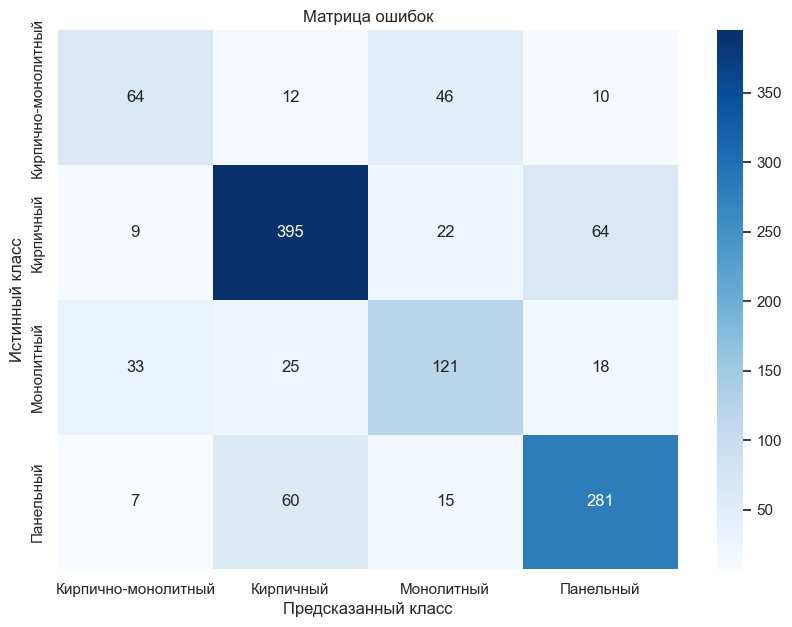

In [120]:
df_model = df[df['house_wall_type'].isin(['Кирпичный', 'Панельный', 'Монолитный', 'Кирпично-монолитный'])].copy()

# Разделим данные на признаки и целевую переменную
features = ['city', 'lat','lon', 'house_floors', 'price_sq', 'balconies']
target = 'house_wall_type'

categorical_features = ['city']

# Создаем CatBoostClassifier
catboost_model = CatBoostClassifier(random_state=42)

# Определяем метрики для оценки
metrics_to_calculate = [accuracy_score, f1_score, precision_score, recall_score]

# Вызываем функцию
trained_model, predictions, metrics = train_evaluate_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=catboost_model,
    metric_funcs=metrics_to_calculate,
    categorical_features=categorical_features,
    metric_averages={'f1_score': 'weighted', 'precision_score': 'weighted', 'recall_score': 'weighted'}
)

В целом модель достаточно среднего качества, но пропусков всего 216 относительно 6619 записей штук, можно ею воспользоваться для заполнения пропусков.

In [121]:
# Заполнение пропущенных значений
df = fill_missing_with_model(
    df=df,
    model=trained_model,
    features=features,
    target=target
)

Пропущенные значения в колонке 'house_wall_type' успешно заполнены с помощью модели.


Далее таким же образом заполним столбец build_year

In [122]:
df['build_year'].describe()

count    5801.000000
mean     1987.293053
std        38.394548
min        23.000000
25%      1968.000000
50%      1983.000000
75%      2016.000000
max      2027.000000
Name: build_year, dtype: float64

Существует странное значение 23, вероятно подразумевалось 2023, заменим это значение.

In [123]:
df['build_year'] = df['build_year'].replace(23, 2023)

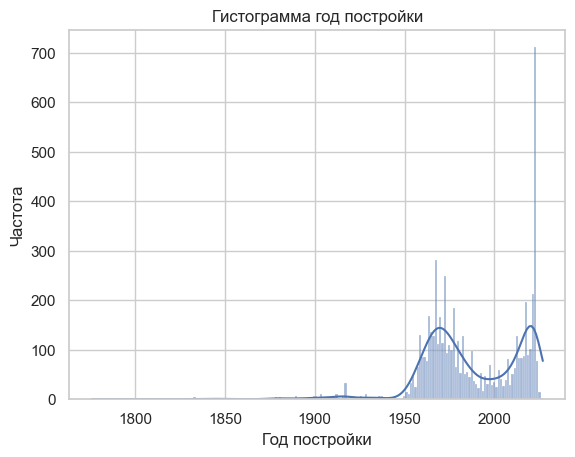

In [124]:
# Построение гистограммы с 100 bins
sns.histplot(df['build_year'], bins=200, kde=True)
plt.title('Гистограмма год постройки')
plt.xlabel('Год постройки')
plt.ylabel('Частота')
plt.show()

Видно что распределение бимодальное, в середине 60 виден бум строительства, потом идёт спад, и снова бум строительства в начале нулевых

Сделаем модель, которая будет прогнозировать год строительства на основе города, типа дома стены, количества комнат, количества этажей в доме, координат, цены и количества балконов. Город влияет на возраст построек, так как в старых городах может быть больше исторических зданий, а в новых — современные дома. Тип стен также связан с годом постройки, так как определённые материалы были популярны или доступны в разные периоды времени. Планировка и количество комнат могут быть характерными для определённых временных периодов. Этажность дома указывает на эпоху строительства: в определённые периоды чаще строились многоэтажные дома (например, панельные дома в советское время), а в другие — малоэтажные (например, коттеджи или частные дома). Цена может быть косвенно связана с годом постройки, так как стоимость квадратного метра может учитывать состояние дома, которое, в свою очередь, зависит от года постройки. Наличие и количество балконов может быть характерным для определённых типов домов, которые строились в конкретные временные периоды. Георафическое расположение даёт понимание о регионе, что может быть связано с годом постройки из-за различий в строительных нормах, климатических условиях и исторических особенностях.

In [125]:
# Проверка наличия необходимых столбцов
required_columns = ['build_year', 'city', 'house_wall_type', 'rooms','house_floors', 'lat', 'lon', 'balconies']
df_model = df.dropna(subset=required_columns).copy()

# Разделим данные на признаки и целевую переменную
features = ['city', 'house_wall_type', 'rooms', 'house_floors', 'balconies', 'lat', 'lon']
target = 'build_year'

# Убедимся, что категориальные признаки переданы корректно
categorical_features = ['city', 'house_wall_type']

# Создаем модель CatBoostRegressor
catboost_model = CatBoostRegressor(random_state=42)

# Определяем метрики для оценки
metrics_to_calculate = [mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error]

# Вызываем функцию
trained_model, predictions, metrics = train_evaluate_regression_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=catboost_model,
    metric_funcs=metrics_to_calculate,
    categorical_features=categorical_features
)

Метрики качества модели регрессии:
mean_absolute_error: 6.458
mean_squared_error: 128.141
r2_score: 0.856
mean_absolute_percentage_error: 0.327
rmse: 11.32


Получили модель довольного высокого качества для заполнения пропусков, воспользуемся ею.

In [126]:
df = fill_missing_regression(
    df=df,
    model=trained_model,
    features=features,
    target='build_year'
)

Пропущенные значения в колонке 'build_year' успешно заполнены с помощью модели.


Можно наблюдать что в данных существует много выбросов, надо посмотреть в каких столбцах выбросы.

In [127]:
nan_count = df.isna().sum()
nan_count_nonzero = nan_count[nan_count != 0].sort_values(ascending=False)
print(nan_count_nonzero)

all_data.object_info.window_view[4].display_name       6688
all_data.house.parking[4].display_name                 6688
all_data.object_info.window_view[3].display_name       6679
all_data.house.parking[3].display_name                 6678
all_data.house.security[3].display_name                6663
all_data.object_info.window_view[2].display_name       6648
all_data.house.parking[2].display_name                 6623
all_data.house.security[2].display_name                6556
all_data.house.parking[1].display_name                 6493
all_data.object_info.garage_type.display_name          6443
all_data.house.security[1].display_name                6287
all_data.object_info.window_view[1].display_name       6245
all_data.house.infrastructure[4].display_name          6008
all_data.house.infrastructure[3].display_name          5792
all_data.object_info.loggias                           5722
all_data.legal_options.years_ownership.display_name    5677
all_data.house.infrastructure[2].display

Очень много столбцов состоящих из почти полностью пустых значений, для моделей информации они не несут их следует выбросить из df. Но для анализа они вполне подойдут. Кроме того, id и offer_views сами по себе также не несут нужно нам информации, их тоже надо выкинуть.

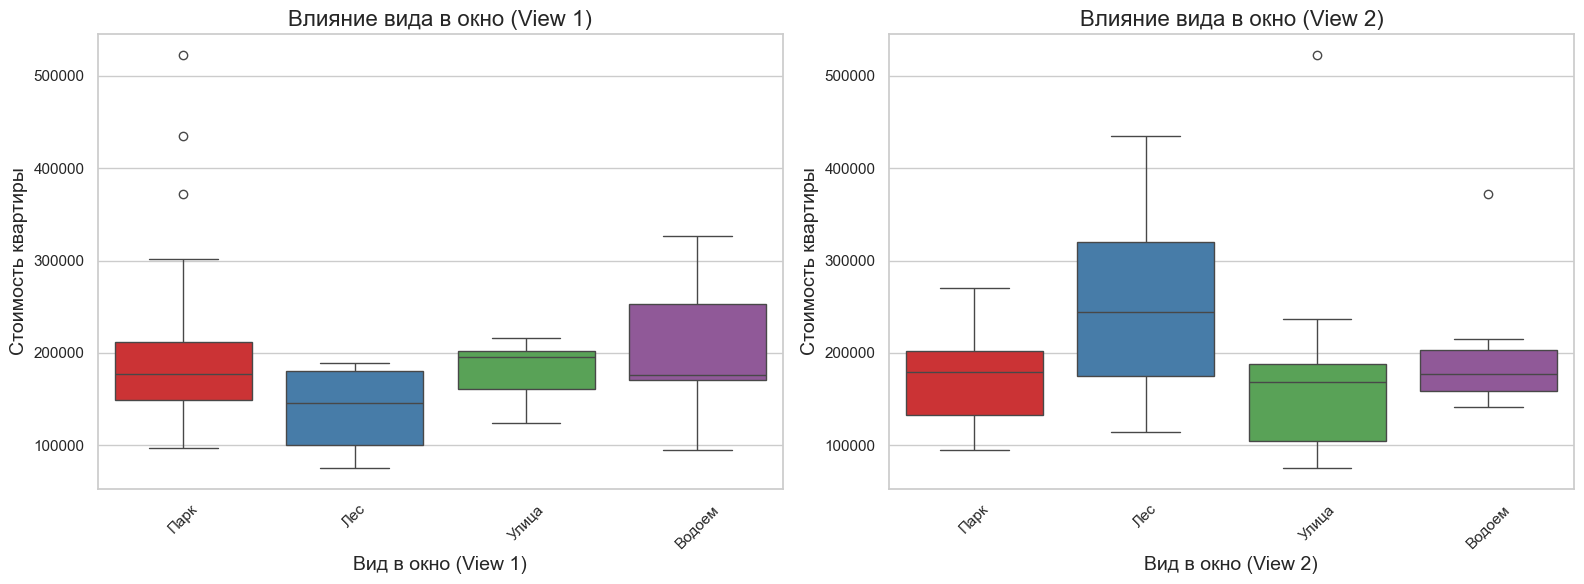

In [128]:
plot_price_by_categories(
    df=df,
    cat_col1='all_data.object_info.window_view[1].display_name',
    cat_col2='all_data.object_info.window_view[2].display_name',
    price_col='price_sq',
    title1='Влияние вида в окно (View 1)',
    xlabel1='Вид в окно (View 1)',
    title2='Влияние вида в окно (View 2)',
    xlabel2='Вид в окно (View 2)',
    ylabel='Стоимость квартиры',
    palette='Set1'
)

Влияние "Вид в окно" на стоимость квартиры противоречивые, поэтому вывод сделать однозначный нельзя.

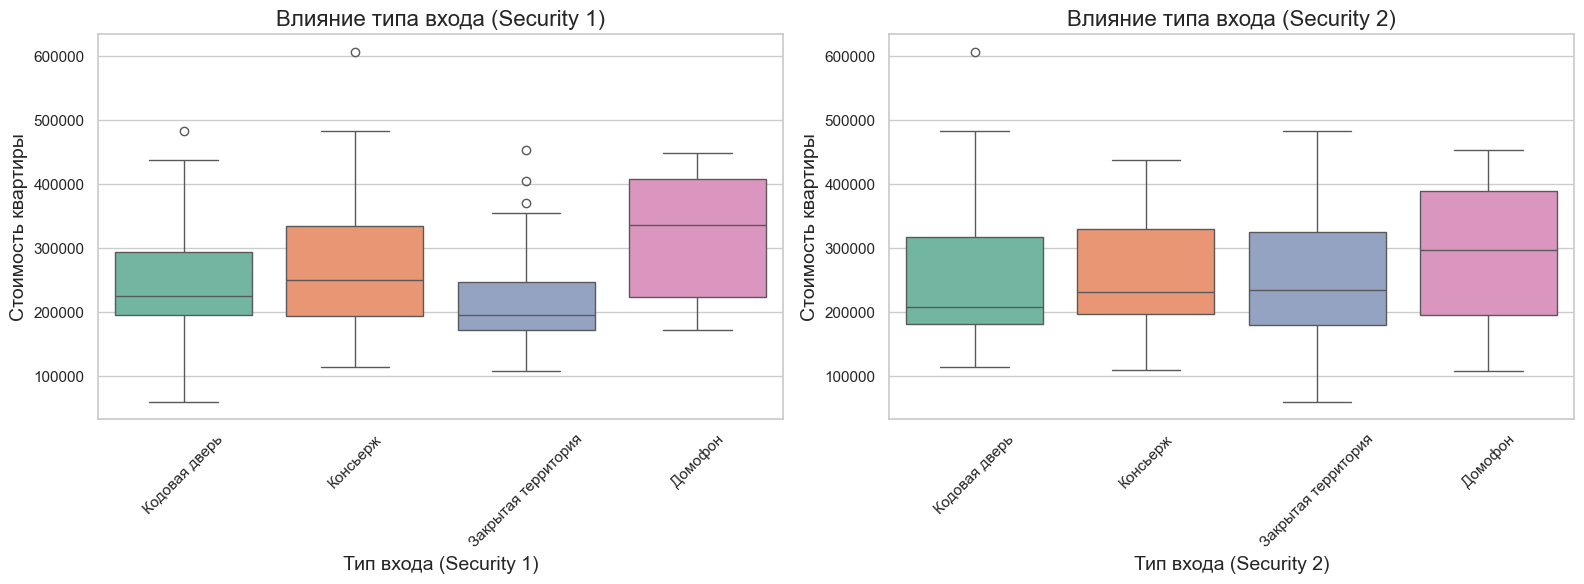

In [129]:
plot_price_by_categories(
    df=df,
    cat_col1='all_data.house.security[1].display_name',
    cat_col2='all_data.house.security[2].display_name',
    price_col='price_sq',
    title1='Влияние типа входа (Security 1)',
    xlabel1='Тип входа (Security 1)',
    title2='Влияние типа входа (Security 2)',
    xlabel2='Тип входа (Security 2)',
    ylabel='Стоимость квартиры',
    palette='Set2'
)

Тоже самое по "Тип входа".

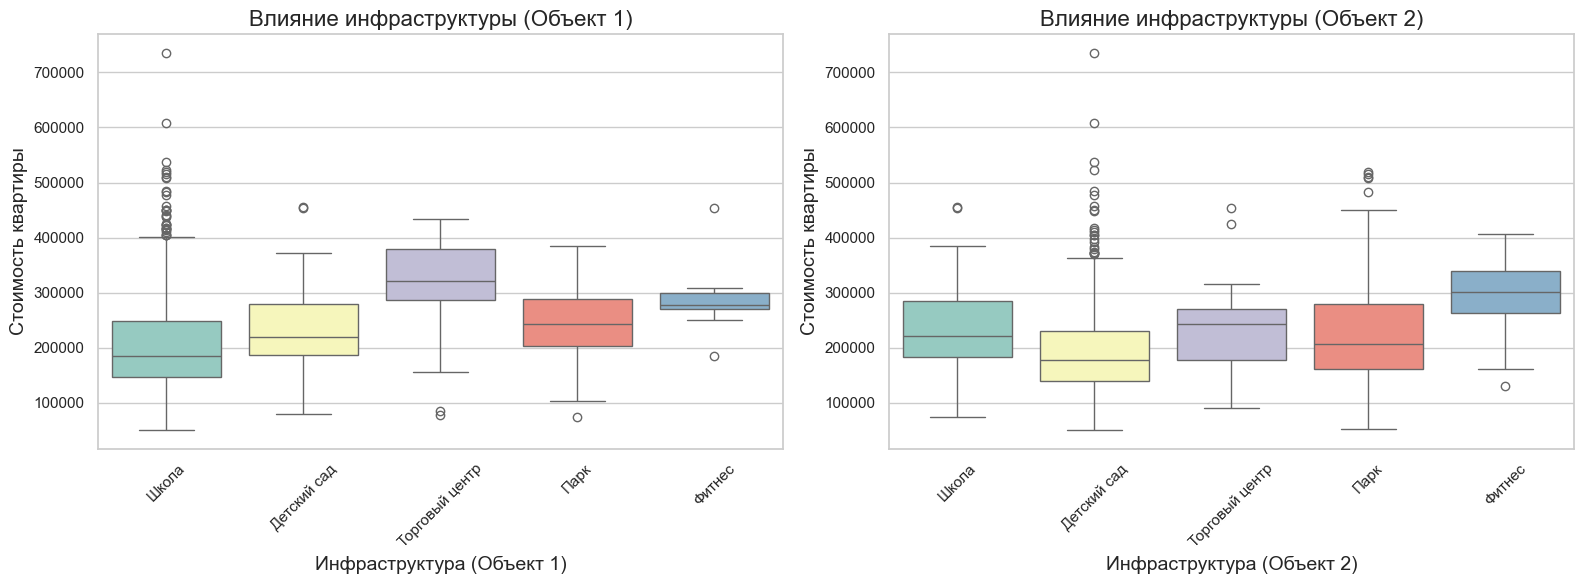

In [130]:
plot_price_by_categories(
    df=df,
    cat_col1='all_data.house.infrastructure[0].display_name',
    cat_col2='all_data.house.infrastructure[1].display_name',
    price_col='price_sq',
    title1='Влияние инфраструктуры (Объект 1)',
    xlabel1='Инфраструктура (Объект 1)',
    title2='Влияние инфраструктуры (Объект 2)',
    xlabel2='Инфраструктура (Объект 2)',
    ylabel='Стоимость квартиры',
    palette='Set3'
)

Тут такая же история, разные столбцы с одной и той же информацией показывают разную информацию. Таким образом на эти столбцы полагаться нельзя и их следует удалить.

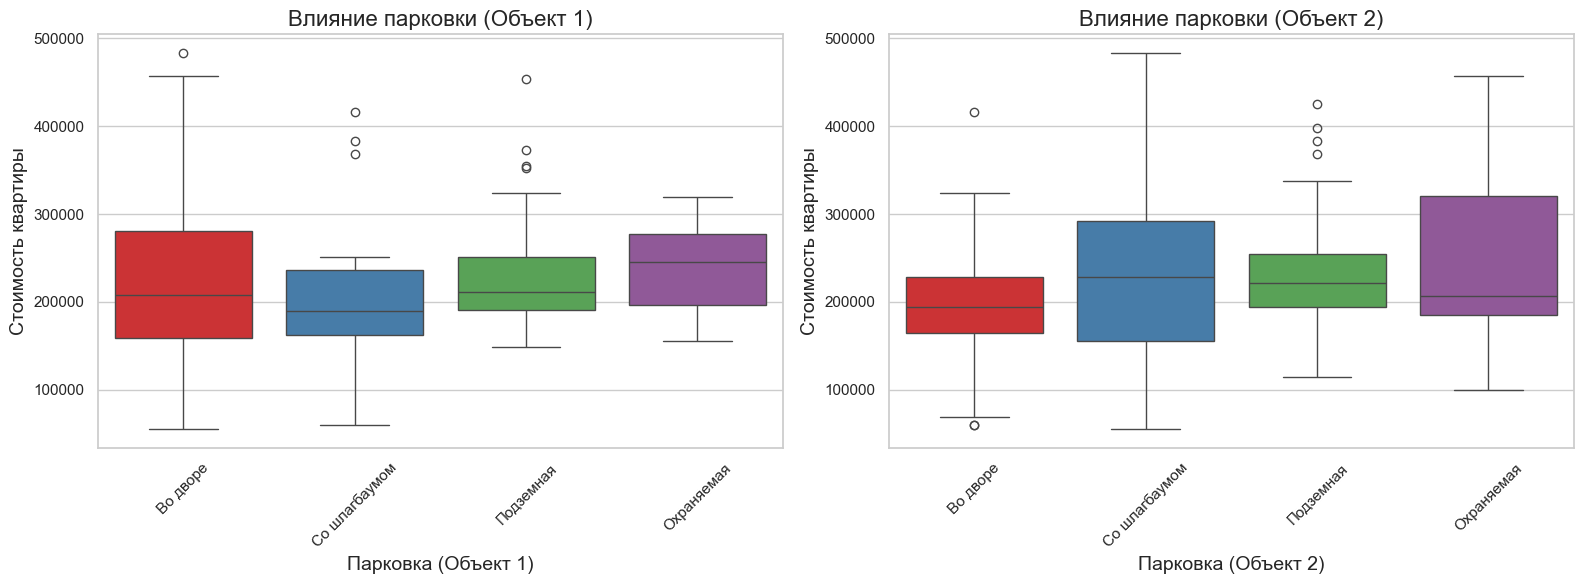

In [131]:
plot_price_by_categories(
    df=df,
    cat_col1='all_data.house.parking[0].display_name',
    cat_col2='all_data.house.parking[1].display_name',
    price_col='price_sq',
    title1='Влияние парковки (Объект 1)',
    xlabel1='Парковка (Объект 1)',
    title2='Влияние парковки (Объект 2)',
    xlabel2='Парковка (Объект 2)',
    ylabel='Стоимость квартиры',
    palette='Set1'
)

Такая же картина по парковке.

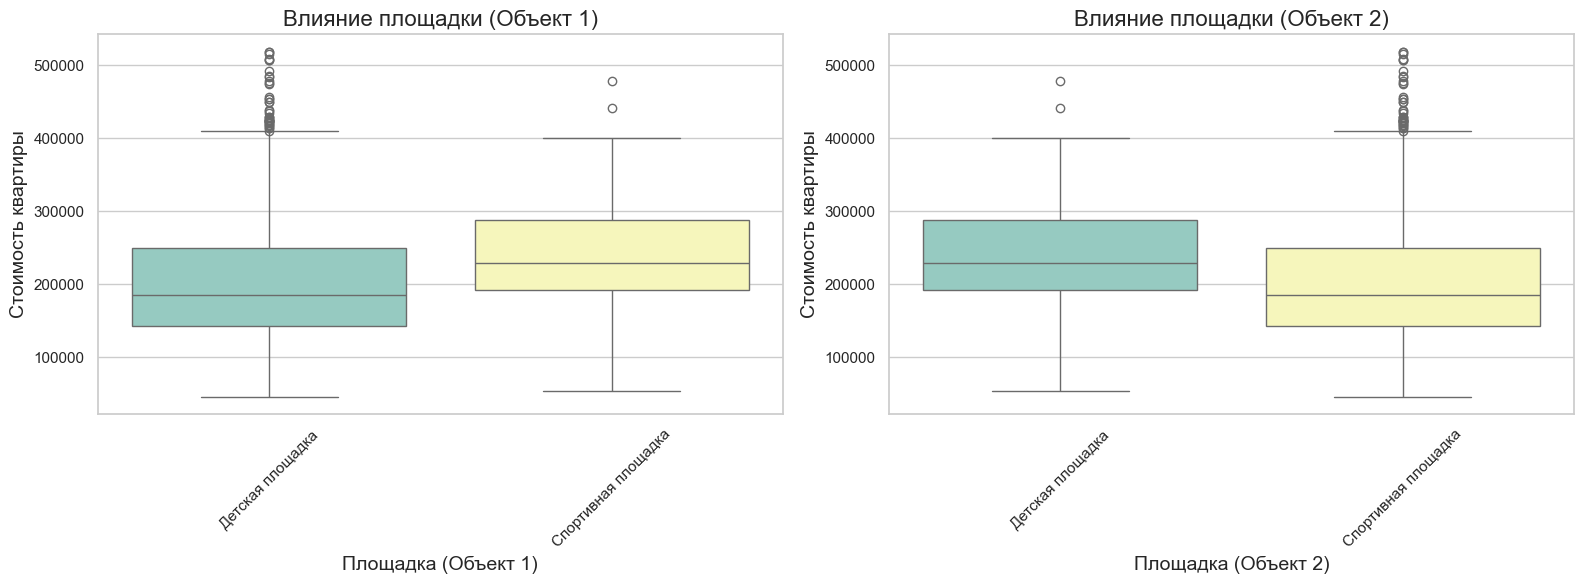

In [132]:
plot_price_by_categories(
    df=df,
    cat_col1='all_data.house.yard[0].display_name',
    cat_col2='all_data.house.yard[1].display_name',
    price_col='price_sq',
    title1='Влияние площадки (Объект 1)',
    xlabel1='Площадка (Объект 1)',
    title2='Влияние площадки (Объект 2)',
    xlabel2='Площадка (Объект 2)',
    ylabel='Стоимость квартиры',
    palette='Set3'
)

Влияние по типу площадки также противоречивые

Проверим остальные столбцы, которые не имеют дубликатов, но имеют много пропусков среди таких:
all_data.object_info.redevelopment, 
all_data.house.has_garbage_disposer, 
all_data.object_info.living_area, 
all_data.object_info.loggias, 
all_data.object_info.garage_type.display_name, 
all_data.object_info.redevelopment, 
all_data.legal_options.years_ownership.display_name, 
all_data.legal_options.is_owner,  
all_data.legal_options.owner_minors,                    
all_data.legal_options.residence_minors,                                   
all_data.legal_options.mortgage,                                                   
all_data.legal_options.is_individual,
bathroom_type

In [133]:
df['all_data.legal_options.is_owner'].value_counts()

all_data.legal_options.is_owner
False    2279
Name: count, dtype: int64

Столбец all_data.legal_options.is_owner имеет только один одно значение False, попробуем заполнить Nan значения True и проверить на box plot существует ли статистически значимое влияние.

In [134]:
df['all_data.legal_options.is_owner'] = df['all_data.legal_options.is_owner'].fillna(True)

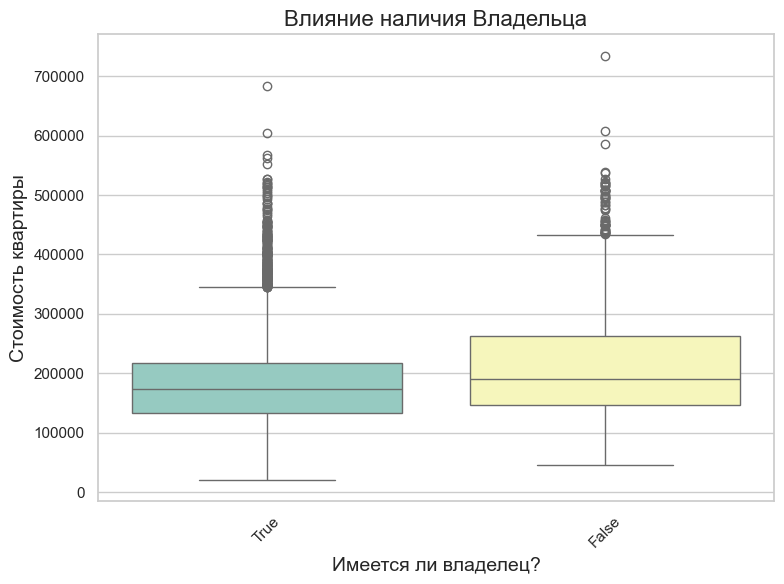

In [135]:
plot_price_by_category(
    df=df,
    cat_col='all_data.legal_options.is_owner',
    price_col='price_sq',
    title='Влияние наличия Владельца',
    xlabel='Имеется ли владелец?',
    ylabel='Стоимость квартиры',
    palette='Set3'
)

In [136]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.legal_options.is_owner')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value:.8f}")

Статистика Краскела-Уоллиса: 104.3957
P-значение: 0.00000000


Видно что существует статистически значимое влияния столбца all_data.legal_options.is_owner при заполнении пустых значений True.
Оставим этот столбец пока в dataframe, далее проверим помогает ли этот столбец модели при решении задачи прогнозирования цены квартиры.

В датасете существует два столбца несущих одну и ту же информацию: all_data.object_info.living_area и area. Необходимо проверить не коррелируют ли они друг с другом и не стоит ли отсавить один из них

In [137]:
df['all_data.object_info.living_area'] = df['all_data.object_info.living_area'].str.replace(',', '.').astype(float)
print(f"Корреляция цены со столбцом all_data.object_info.living_area: {df['all_data.object_info.living_area'].corr(df['price_sq']):.4f}")

Корреляция цены со столбцом all_data.object_info.living_area: -0.4565


In [138]:
print(f"Корреляция цены со столбцом all_data.object_info.living_area: {df['area'].corr(df['price_sq']):.4f}")

Корреляция цены со столбцом all_data.object_info.living_area: -0.4935


In [139]:
print(f"Корреляция all_data.object_info.living_area и area: {df['all_data.object_info.living_area'].corr(df['area']):.4f}")

Корреляция all_data.object_info.living_area и area: 0.8736


Видно что столбцы all_data.object_info.living_area и area сильно коррелируют друг с другом и почти одинаковая корреляция с целевой переменной. Что в целом не удивительно, столбцы несут практически одинаковую информацию. С учетом того, что all_data.object_info.living_area имеет более 2000 пропусков, можем удалить этот столбец.

In [140]:
df['all_data.object_info.loggias'].value_counts()

all_data.object_info.loggias
1.0    730
0.0    209
2.0     26
3.0      3
Name: count, dtype: int64

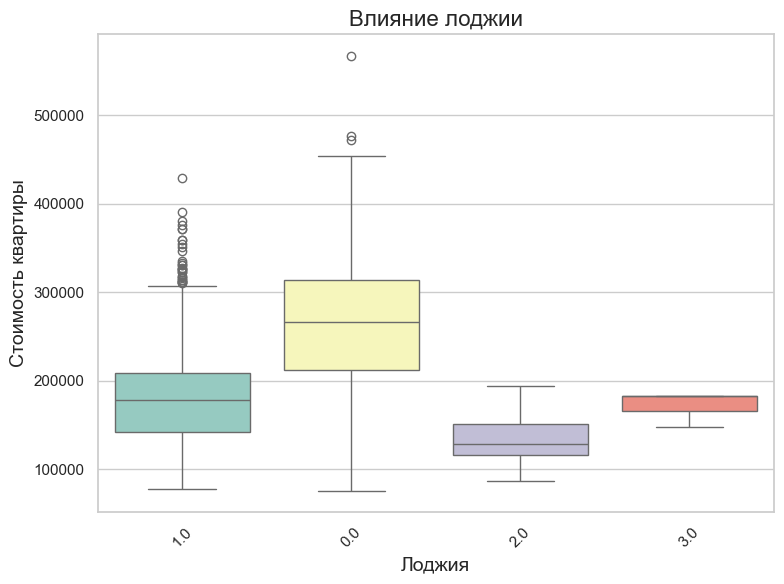

In [141]:
plot_price_by_category(
    df=df,
    cat_col='all_data.object_info.loggias',
    price_col='price_sq',
    title='Влияние лоджии',
    xlabel='Лоджия',
    ylabel='Стоимость квартиры',
    palette='Set3'
)

In [142]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.object_info.loggias')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 235.3432
P-значение: 9.671681232582661e-51


Заметно что существует значительное влияние столбца "Лоджия" на цену квартиры. Попробуем заполнить этот столбец основываясь на следующих данных: год строительства, тип стены дома, город и количество балконов. Возьмем только наиболее распространенные классы 1 и 2.

Метрики качества модели:
accuracy_score: 0.9415
f1_score: 0.9619
precision_score: 0.9720
recall_score: 0.9521


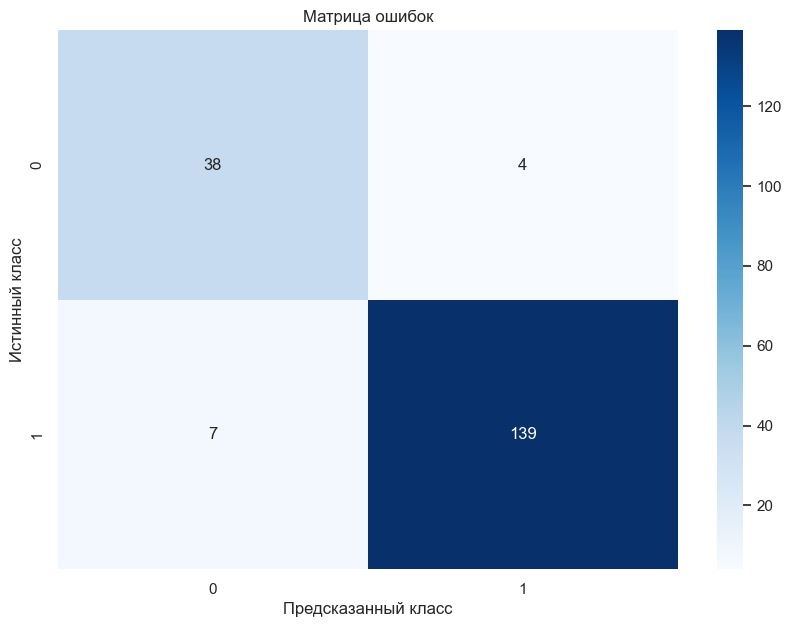

In [143]:
# Проверка наличия необходимых столбцов
required_columns = ['all_data.object_info.loggias', 'build_year', 'city', 'house_wall_type', 'balconies']

# Фильтрация данных
df_model = df[df['all_data.object_info.loggias'].isin([0, 1])].copy()

# Удаление пропусков до разделения на train/test
df_model.dropna(subset=required_columns, inplace=True)

# Разделение данных на признаки и целевую переменную
features = ['build_year', 'city', 'house_wall_type', 'balconies']
target = 'all_data.object_info.loggias'

# Категориальные признаки
categorical_features = ['city', 'house_wall_type']

# Кодируем целевую переменную
encoder = LabelEncoder()
df_model['all_data.object_info.loggias'] = encoder.fit_transform(df_model['all_data.object_info.loggias'])

# Создаем CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.5,
    depth=4,
    random_state=21,
    verbose=0  # Отключаем verbose при обучении в функции
)

# Определяем метрики
metrics_to_calculate = [accuracy_score, f1_score, precision_score, recall_score]

# Определяем метод усреднения для f1, precision и recall
metric_averages = {'f1_score': 'binary', 'precision_score': 'binary', 'recall_score': 'binary'}

# Вызываем функцию для обучения и оценки модели
trained_model, predictions, metrics = train_evaluate_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=catboost_model,
    metric_funcs=metrics_to_calculate,
    categorical_features=categorical_features,
    test_size=0.2,
    random_state=42,
    stratify_by_target=True,
    metric_averages=metric_averages
)


Получилась модель довольно выского качества, воспользуемся ей для заполнения пропущенных значений.

In [144]:
# Заполнение пропущенных значений
df = fill_missing_with_model(
    df=df,
    model=trained_model,
    features=features,
    target=target
)

Пропущенные значения в колонке 'all_data.object_info.loggias' успешно заполнены с помощью модели.


In [145]:
df['all_data.object_info.garage_type.display_name'].value_counts()

all_data.object_info.garage_type.display_name
Наземная парковка         187
Подземная парковка         55
Многоуровневый паркинг      5
Name: count, dtype: int64

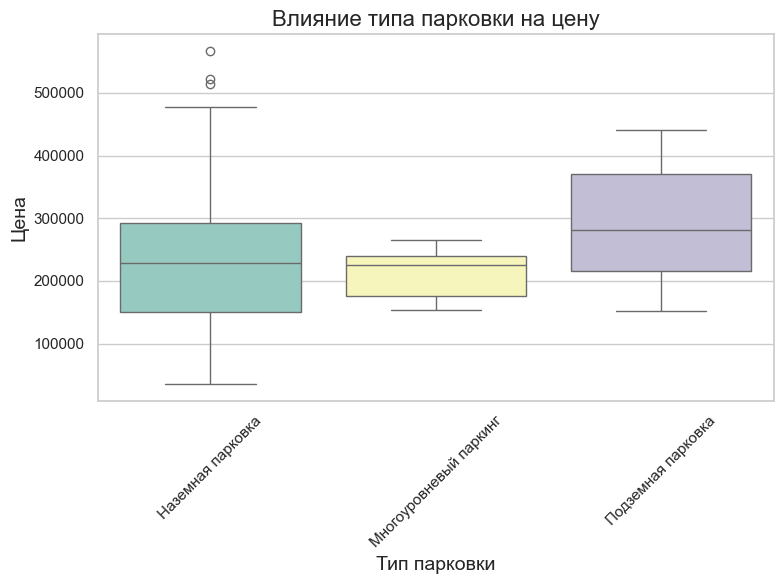

In [146]:
plot_price_by_category(
    df=df,
    cat_col='all_data.object_info.garage_type.display_name',
    price_col='price_sq',
    title='Влияние типа парковки на цену',
    xlabel='Тип парковки',
  palette='Set3'
)

In [147]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.object_info.garage_type.display_name')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 15.5651
P-значение: 0.0004169376798542826


Заметно что существует значительное влияние типа парковки на цену квартиры. Заполним пропущенные значния исходя из того что у нас в подавляющем распространена наземная парковка.

In [148]:
df['all_data.object_info.garage_type.display_name'] = df['all_data.object_info.garage_type.display_name'].fillna('Наземная парковка')

In [149]:
df['all_data.legal_options.years_ownership.display_name'].value_counts()

all_data.legal_options.years_ownership.display_name
Больше пяти        575
Меньше трех        324
От трех до пяти    114
Name: count, dtype: int64

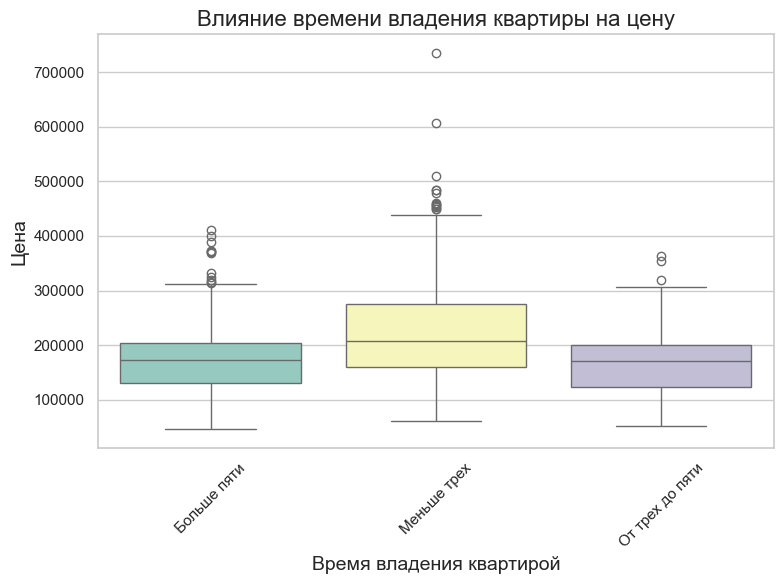

In [150]:
# Использование функции plot_price_by_category для анализа времени владения
plot_price_by_category(
    df=df,
    cat_col='all_data.legal_options.years_ownership.display_name',
    price_col='price_sq',
    title='Влияние времени владения квартиры на цену',
    xlabel='Время владения квартирой',
  palette='Set3'
)

In [151]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.legal_options.years_ownership.display_name')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 70.9327
P-значение: 3.9551484032430166e-16


Время владения владельцем влияет на цену квартиры, тем не менее пропусков, которые мы не можем заполнить слишком много поэтому также удалим этот столбец. 

In [152]:
df['all_data.legal_options.owner_minors'].value_counts()

all_data.legal_options.owner_minors
False    1629
True       31
Name: count, dtype: int64

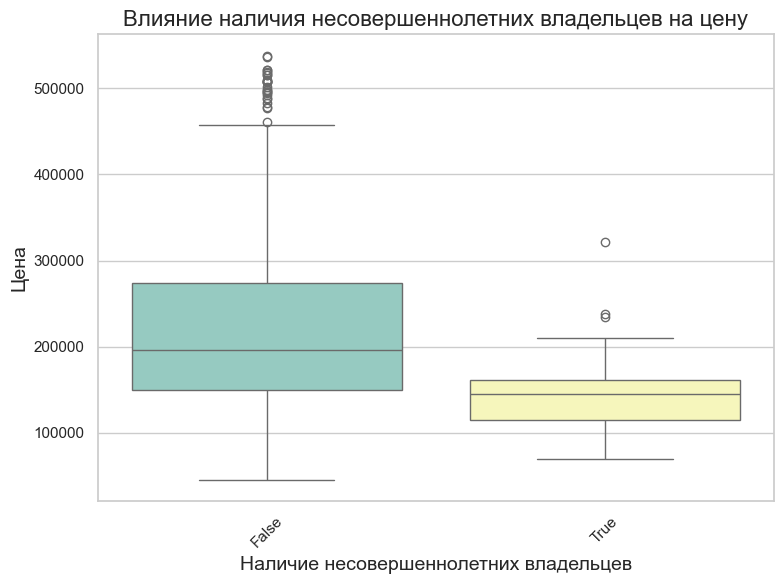

In [153]:
plot_price_by_category(
    df=df,
    cat_col='all_data.legal_options.owner_minors',
    price_col='price_sq',
    title='Влияние наличия несовершеннолетних владельцев на цену',
    xlabel='Наличие несовершеннолетних владельцев',
    palette='Set3'
)

In [154]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.legal_options.owner_minors')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 16.9102
P-значение: 3.919080950208081e-05


В целом можно заметить что совершеннолетие владельца значительно влияет на стоимость квартиры. Заполним пропущенные значения предполагая, что владелец совершеннолетний.

In [155]:
df['all_data.legal_options.owner_minors'] = df['all_data.legal_options.owner_minors'].fillna('False')

In [156]:
df['all_data.legal_options.is_individual'].value_counts()

all_data.legal_options.is_individual
False    1864
True      415
Name: count, dtype: int64

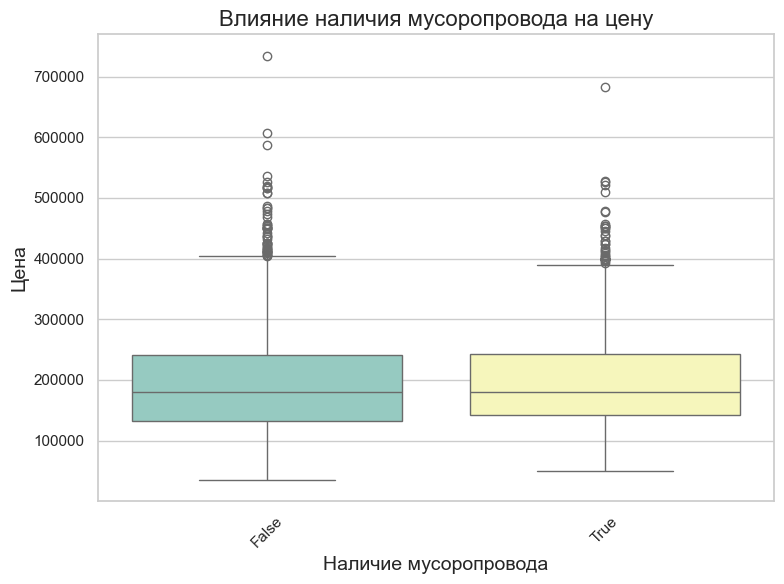

In [157]:
plot_price_by_category(
    df=df,
    cat_col='all_data.house.has_garbage_disposer',
    price_col='price_sq',
    title='Влияние наличия мусоропровода на цену',
    xlabel='Наличие мусоропровода',
    palette='Set3'
)

In [158]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.house.has_garbage_disposer')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value:.4f}")

Статистика Краскела-Уоллиса: 1.2206
P-значение: 0.2692


Столбец о наличии мусоропровода не влияет на цену квартиры.

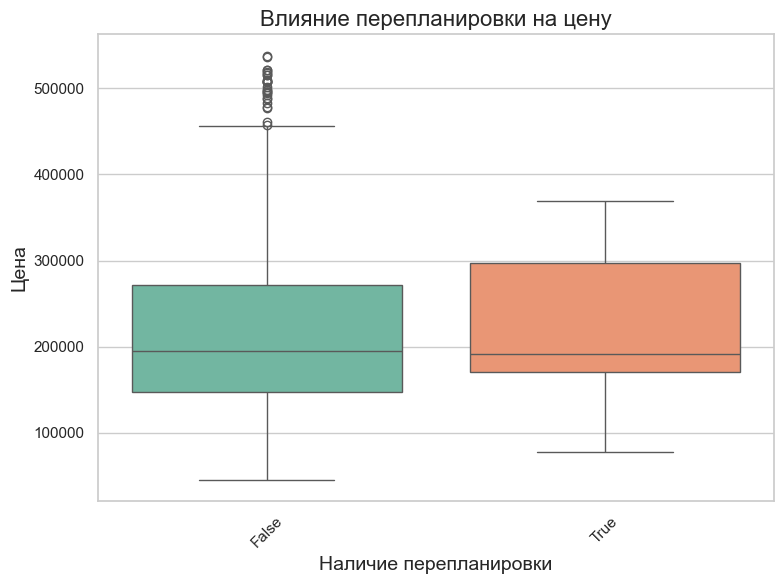

In [159]:
plot_price_by_category(
    df=df,
    cat_col='all_data.object_info.redevelopment',
    price_col='price_sq',
    title='Влияние перепланировки на цену',
    xlabel='Наличие перепланировки',
    palette='Set2'
)

In [160]:
statistic, p_value = kruskal_wallis_test(df, 'all_data.object_info.redevelopment')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value:.4f}")

Статистика Краскела-Уоллиса: 0.0279
P-значение: 0.8674


Можно заметить что перепланировка не влияет на цену квартиры, смело исключаем этот столбец, помимо этого в этом столбце слишком много пропусков.

In [161]:
df['bathroom_type'].value_counts()

bathroom_type
Совмещенный     1071
Раздельный       405
Более одного       6
Name: count, dtype: int64

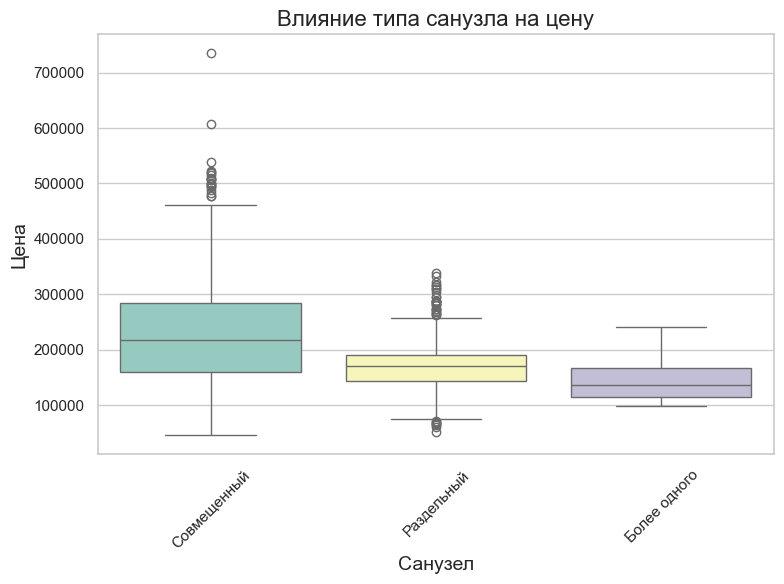

In [162]:
plot_price_by_category(
    df=df,
    cat_col='bathroom_type',
    price_col='price_sq',
    title='Влияние типа санузла на цену',
    xlabel='Санузел',
    palette='Set3'
)

In [163]:
statistic, p_value = kruskal_wallis_test(df, 'bathroom_type')

print(f"Статистика Краскела-Уоллиса: {statistic}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 121.38011662137363
P-значение: 4.3918001507382945e-27


Видно что тип санузла влияет на цену квартиры. Тем не менее там слишком много пропусков. Посмотрим как зависит тип санузла от года различных факторов. 

In [164]:
df['quinquennium'] = (df['build_year'] // 5) * 5

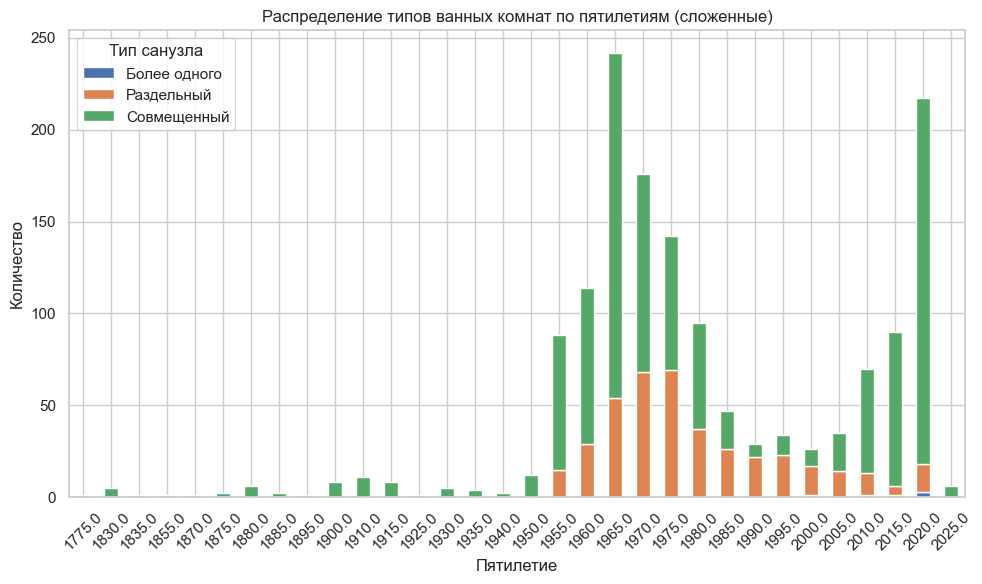

In [165]:
decade_bathroom_counts = df.groupby('quinquennium')['bathroom_type'].value_counts().unstack(fill_value=0)

sns.set_style('whitegrid')

decade_bathroom_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Распределение типов ванных комнат по пятилетиям (сложенные)')
plt.xlabel('Пятилетие')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend(title='Тип санузла')
plt.tight_layout()
plt.show()

Видно что раздельный санузел более характерен для домой прошлого столетия, тем не менее совмещенной санузел, также часто используется в прошлом столетии. Также видно что дом построенные до 1950 года имеют полностью совмещенный санузел. Видно что с девяностых по нулевые побольшей части распространены раздельные санузлы.

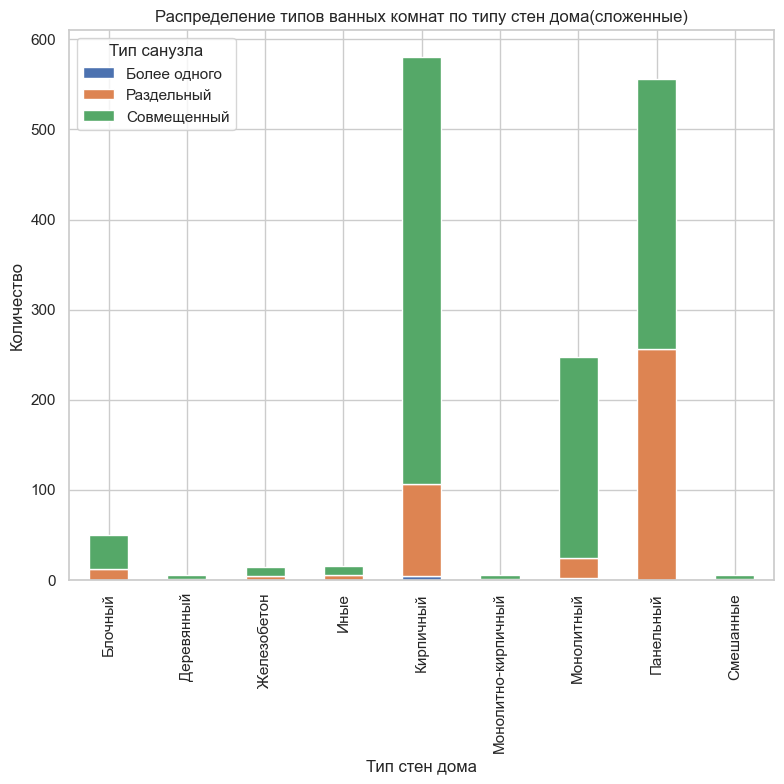

In [166]:
decade_bathroom_counts = df.groupby('house_wall_type')['bathroom_type'].value_counts().unstack(fill_value=0)

sns.set_style('whitegrid')

decade_bathroom_counts.plot(kind='bar', stacked=True, figsize=(8, 8))
plt.title('Распределение типов ванных комнат по типу стен дома(сложенные)')
plt.xlabel('Тип стен дома')
plt.ylabel('Количество')
plt.xticks(rotation=90) 
plt.legend(title='Тип санузла')
plt.tight_layout()
plt.show()

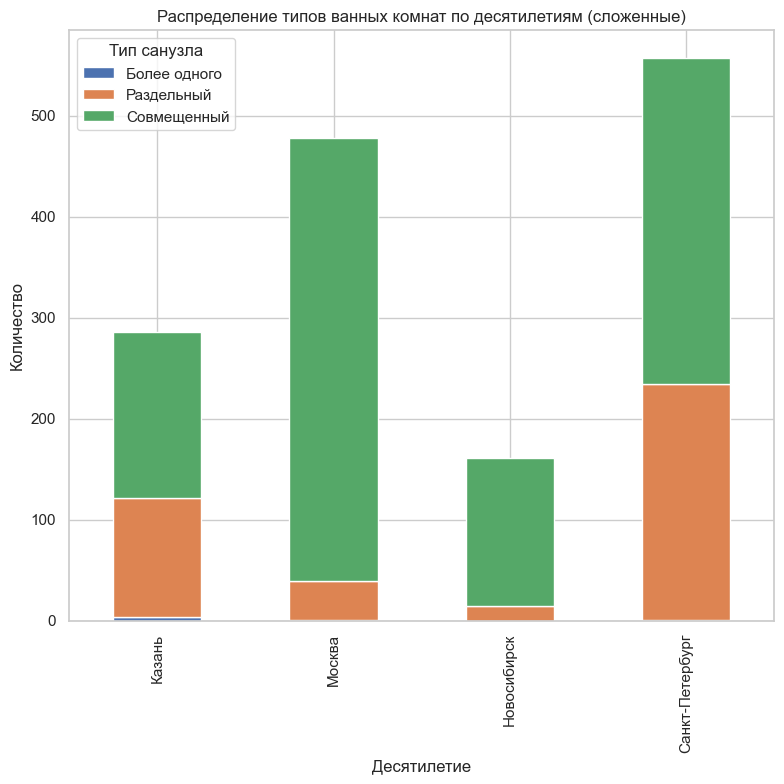

In [167]:
decade_bathroom_counts = df.groupby('city')['bathroom_type'].value_counts().unstack(fill_value=0)

sns.set_style('whitegrid')

decade_bathroom_counts.plot(kind='bar', stacked=True, figsize=(8, 8))
plt.title('Распределение типов ванных комнат по десятилетиям (сложенные)')
plt.xlabel('Десятилетие')
plt.ylabel('Количество')
plt.xticks(rotation=90) 
plt.legend(title='Тип санузла')
plt.tight_layout()
plt.show()

Видно что в Питере и в Казань распространены раздельные санузлы, посмотрим в этих городах зависимость санузла от типа стен дома.

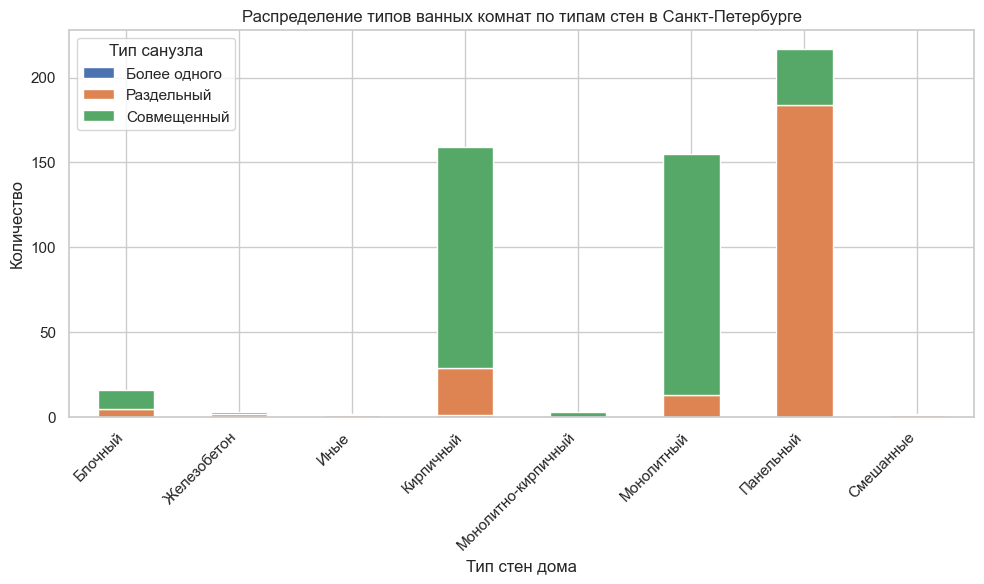

In [168]:
# Фильтруем DataFrame по городу и десятилетиям
filtered_df = df[
    (df['city'] == 'Санкт-Петербург') 
]

# Проверяем, есть ли данные после фильтрации
if not filtered_df.empty:
    # Группируем отфильтрованный DataFrame
    decade_bathroom_counts = filtered_df.groupby('house_wall_type')['bathroom_type'].value_counts().unstack(fill_value=0)

    # Настройка стиля графика
    sns.set_style('whitegrid')

    # Построение графика
    decade_bathroom_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Распределение типов ванных комнат по типам стен в Санкт-Петербурге')
    plt.xlabel('Тип стен дома')
    plt.ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Тип санузла')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для Санкт-Петербурга в диапазоне десятилетий")

Можно наблюдать что панельные дома в Санкт-Петербурге имеют "Раздельный" санузел.

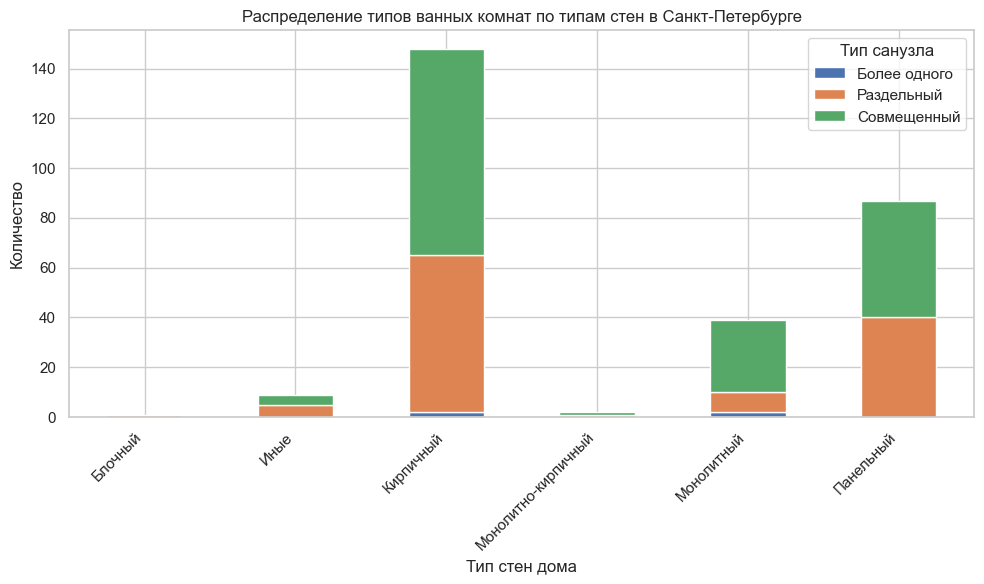

In [169]:
filtered_df = df[
    (df['city'] == 'Казань') &
    (df['quinquennium'] >= 1950) &
    (df['quinquennium'] <= 2025)
]


# Проверяем, есть ли данные после фильтрации
if not filtered_df.empty:
    # Группируем отфильтрованный DataFrame
    decade_bathroom_counts = filtered_df.groupby('house_wall_type')['bathroom_type'].value_counts().unstack(fill_value=0)

    # Настройка стиля графика
    sns.set_style('whitegrid')

    # Построение графика
    decade_bathroom_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Распределение типов ванных комнат по типам стен в Санкт-Петербурге')
    plt.xlabel('Тип стен дома')
    plt.ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Тип санузла')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для Санкт-Петербурга в диапазоне десятилетий")

По Казани однозначного вывода сделать нельзя.

Заполним  пропущенные значения обучив классификационную модель на имеющихся данных и через нее заполним пропуски.
Будем предсказывать на основе build_year, city, house_wall_type.

Метрики качества модели:
accuracy_score: 0.8480
f1_score: 0.8970
precision_score: 0.8829
recall_score: 0.9116


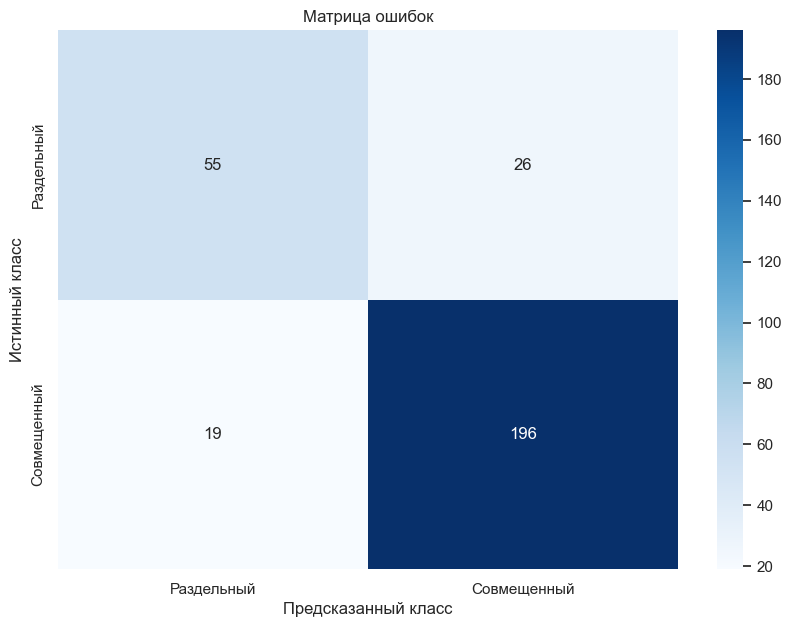

In [170]:
# Фильтрация данных: оставляем только классы "Совмещенный" и "Раздельный"
df_model = df[df['bathroom_type'].isin(['Совмещенный', 'Раздельный'])]

# Удалим пропуски
df_model = df_model.dropna(subset=required_columns)

# Разделим данные на признаки и целевую переменную
features = ['build_year', 'city', 'house_wall_type']
target = 'bathroom_type'
categorical_features = ['city', 'house_wall_type']



# Создаем CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.5,
    depth=4,
    random_state=21
)

metric_funcs = [accuracy_score, f1_score, precision_score, recall_score]
metric_averages = {'f1_score': 'binary', 'precision_score': 'binary', 'recall_score': 'binary'}

# Обучение и оценка модели
trained_model, y_pred, metrics = train_evaluate_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=model,
    metric_funcs=metric_funcs,
    categorical_features=categorical_features,
    metric_averages=metric_averages
)

В целом получлилсаь модель довольно высокого качества для заполнения пропусков, воспользуемся ей для заполнения остальных пропусков.

In [171]:
# Заполнение пропущенных значений
df = fill_missing_with_model(
    df=df,
    model=trained_model,
    features=features,
    target=target
)

Пропущенные значения в колонке 'bathroom_type' успешно заполнены с помощью модели.


Рассмотрим столбец renovation

In [172]:
df['renovation'].value_counts()

renovation
Косметический                      1186
косметический                       613
Требует ремонта                     474
Дизайнерский                        461
Без ремонта                         388
Отсутствует                         125
Требуется                           121
Хороший                              72
Под чистовой ремонт                  44
С отделкой                           39
Частичный ремонт                     20
чистовая отделка                     15
Косметический ремонт                  6
Предчистовая                          5
нормальное                            4
cosmetic                              3
отличное                              2
design                                2
Произведен                            2
Под ключ                              2
Чистовая                              2
предчистовая                          2
хорошее                               2
Чистовая отделка                      1
Подготовка под чистовую отдел

Очень много записей, несущие одну и ту же информацию но записанные разными способами, приведем все к единому стандарту.

In [173]:
df['renovation'] = df['renovation'].str.lower().str.strip()

In [174]:
replacement_dict = {
        'косметический ремонт': 'косметический',
        'cosmetic': 'косметический',
        'требуется косм.ремонт': 'косметический',
        'чистовая отделка': 'под чистовую',
        'чистовая': 'под чистовую',
        'предчистовая': 'под чистовую',
        'предчистовая отделка': 'под чистовую',
        'подготовка под чистовую отделку': 'под чистовую',
        'нормальное': 'хороший',
        'хорошее': 'хороший',
        'отличное': 'хороший',  # Можно рассмотреть создание отдельной категории "отличное"
        'design': 'дизайнерский',
        'под ключ': 'с отделкой',
        'с отделкой': 'с отделкой', # Уже стандартизированное
        'под самоотделку': 'без ремонта', #  Логически близко к "без ремонта"
        'отсутствует': 'без ремонта', #  Логически близко к "без ремонта"
        'требует ремонта': 'без ремонта',
        'требуется': 'без ремонта',
        'под чистовой ремонт': 'без ремонта',
        'no': 'без ремонта',
        'требуется ремонт': 'без ремонта', 
        'под чистовую': 'частичный ремонт',
        'с отделкой': 'частичный ремонт',
        'произведен': 'дизайнерский',
        'хороший': 'дизайнерский'
    }
df['renovation'] = df['renovation'].replace(replacement_dict)

In [175]:
df['renovation'].value_counts()

renovation
косметический       1809
без ремонта         1155
дизайнерский         537
частичный ремонт      59
под чистовую          28
хороший                9
с отделкой             2
Name: count, dtype: int64

In [176]:
statistic, p_value = kruskal_wallis_test(df, 'renovation')

print(f"Статистика Краскела-Уоллиса: {statistic}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 393.73012746099494
P-значение: 6.227424600981094e-82


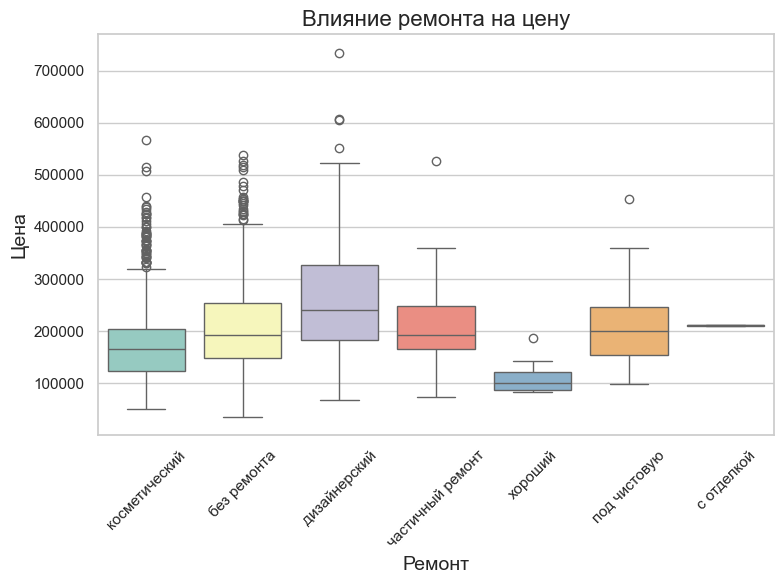

In [177]:
plot_price_by_category(
    df=df,
    cat_col='renovation',
    price_col='price_sq',
    title='Влияние ремонта на цену',
    xlabel='Ремонт',
    palette='Set3'
)

Можнл заметить существенное влияние наличие ремонат на цену, попробуем реализовать модель по заполнению пропусков.

Метрики качества модели:
accuracy_score: 0.7210
f1_score: 0.7090
precision_score: 0.7157
recall_score: 0.7210


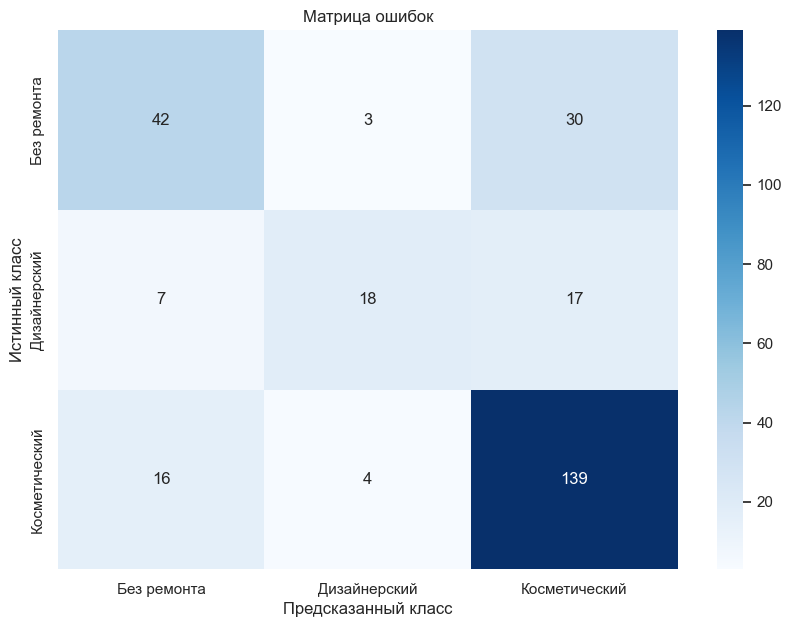

In [178]:
required_columns = ['renovation', 'build_year', 'city', 'house_wall_type', 'rooms', 'area']

# Удалим пропуски
df_model = df_model.dropna(subset=required_columns)

features = ['build_year', 'city', 'house_wall_type', 'rooms', 'area']
target = 'renovation'
categorical_features = ['city', 'house_wall_type']

# CatBoostClassifier
model = CatBoostClassifier(
    verbose=False
)

metric_funcs = [accuracy_score, f1_score, precision_score, recall_score]
metric_averages = {'f1_score': 'weighted', 'precision_score': 'weighted', 'recall_score': 'weighted'}

# Обучение
trained_model, y_pred, metrics = train_evaluate_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=model,
    metric_funcs=metric_funcs,
    categorical_features=categorical_features,
    metric_averages=metric_averages
)


К сожеланию несмотря на статистическую значимость, модель среднего качества и пропусков слишком много, половина от всего датасета, поэтому исключим этот столбец

Проанализируем как влияет время пути пешком до метро на цену.

In [179]:
statistic, p_value = kruskal_wallis_test(df, 'time_on_foot_to_subway')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 424.3105
P-значение: 7.55492430468964e-46


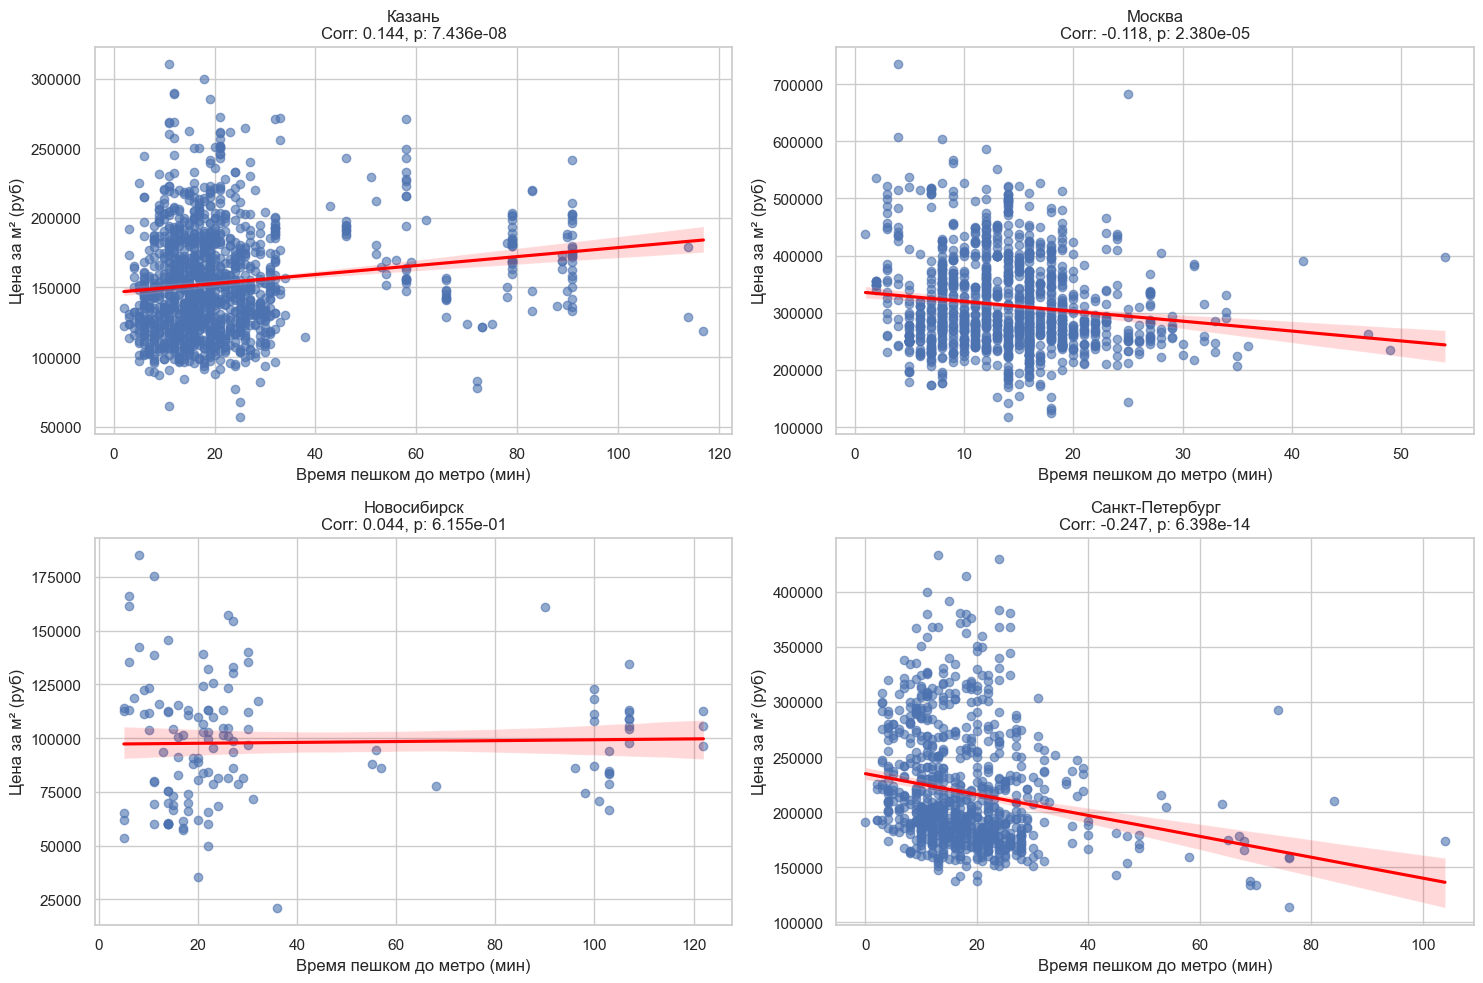

Корреляции Spearman по городам:
                   corr       p
Казань           0.1444  0.0000
Москва          -0.1177  0.0000
Новосибирск      0.0436  0.6155
Санкт-Петербург -0.2470  0.0000


In [180]:
# Фильтрация данных
selected_cities = ['Казань', 'Москва', 'Новосибирск', 'Санкт-Петербург']
df_filtered = df[df['city'].isin(selected_cities)].dropna(subset=['time_on_foot_to_subway', 'price_sq'])

# Создание subplot'ов (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Словарь для хранения корреляций
correlations = {}

for i, city in enumerate(selected_cities):
    city_data = df_filtered[df_filtered['city'] == city]
    if len(city_data) > 3:
        # Spearman корреляция
        corr, p = spearmanr(city_data['time_on_foot_to_subway'], city_data['price_sq'])
        correlations[city] = {'corr': corr, 'p': p}
        
        # lmplot на subplot
        sns.regplot(data=city_data, x='time_on_foot_to_subway', y='price_sq', ax=axes[i], 
                    scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
        axes[i].set_title(f'{city}\nCorr: {corr:.3f}, p: {p:.3e}')
        axes[i].set_xlabel('Время пешком до метро (мин)')
        axes[i].set_ylabel('Цена за м² (руб)')
    else:
        axes[i].text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(city)

plt.tight_layout()
plt.show()

# Таблица корреляций
corr_df = pd.DataFrame(correlations).T
print("Корреляции Spearman по городам:")
print(corr_df.round(4))

К сожалению по графику сказать ничего нельзя.

Text(0, 0.5, 'Плотность')

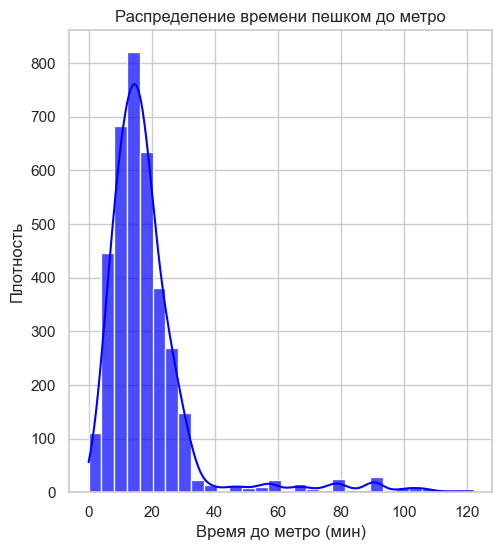

In [181]:
# Фильтрация данных (убираем NaN)
df_filtered = df.dropna(subset=['time_on_foot_to_subway'])

# Создание графика с наложенными гистограммами (плотность для сравнения распределений)
plt.figure(figsize=(12, 6))

# Гистограмма для time_on_foot_to_subway
plt.subplot(1, 2, 1)
sns.histplot(data=df_filtered, x='time_on_foot_to_subway', bins=30, kde=True, color='blue', alpha=0.7)
plt.title('Распределение времени пешком до метро')
plt.xlabel('Время до метро (мин)')
plt.ylabel('Плотность')


Можно видеть что гистограмма имеет много выбросов с уклоном вправо.

Попробуем сделать регрессионную модель.

In [182]:
# Проверка наличия необходимых столбцов
required_columns = ['time_on_foot_to_subway', 'city', 'house_wall_type', 'lat', 'lon', 'build_year']
df_model = df.dropna(subset=required_columns).copy()

# Разделим данные на признаки и целевую переменную
features = ['city', 'house_wall_type', 'lat', 'lon', 'build_year']
target = 'time_on_foot_to_subway'

# Убедимся, что категориальные признаки переданы корректно
categorical_features = ['city', 'house_wall_type']

# Создаем модель CatBoostRegressor
catboost_model = CatBoostRegressor(random_state=42)

# Определяем метрики для оценки
metrics_to_calculate = [mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error]

# Вызываем функцию
trained_model, predictions, metrics = train_evaluate_regression_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=catboost_model,
    metric_funcs=metrics_to_calculate,
    categorical_features=categorical_features
)

# Заполнение пропусков в основном df
df = fill_missing_regression(df, trained_model, features, target)

Метрики качества модели регрессии:
mean_absolute_error: 3.311
mean_squared_error: 22.809
r2_score: 0.899
mean_absolute_percentage_error: 29.401
rmse: 4.78
Пропущенные значения в колонке 'time_on_foot_to_subway' успешно заполнены с помощью модели.


Модель получилось достаточной качественной, несмотря на высокий mape. В целом погрешность в 4-5 минут нас устраивает, поэтому воспользуемся моделью для заполнения пропусков.

Далее создадим дополнительный столбец cluster, проведем кластеризацию на основе координат и цены, создадим столбец, который будет содержать в себе кластеры по ценам и координатам.

Основная идея заключается в том, чтобы выделить географически и ценово однородные группы объектов недвижимости внутри каждого города. Мы предполагаем, что объекты, находящиеся близко друг к другу и имеющие схожую стоимость за квадратный метр, образуют отдельные рыночные сегменты или районы с определенными характеристиками.

Определение количества кластеров для каждого города: Мы не задаем фиксированное количество кластеров для всех городов. Вместо этого, мы динамически определяем количество кластеров для каждого города (num_clusters) на основе двух факторов: Количество объектов недвижимости в городе (num_objects): В городах с большим количеством объявлений можно выделить большее количество кластеров. Население города (population): Население служит дополнительным фактором, позволяющим учесть масштаб города. Более крупные города могут иметь более разнообразную структуру рынка недвижимости, что оправдывает большее количество кластеров. Функция calculate_clusters рассчитывает это количество, беря за основу 5% от количества объектов, но корректируя это значение в зависимости от населения и ограничивая максимальным значением в 10. Кластеризация внутри каждого города: Мы применяем алгоритм K-средних (KMeans) для кластеризации объектов внутри каждого города отдельно. Для каждого города выделяется подмножество данных (city_data). Признаки для кластеризации: Используются географические координаты (lat, lon) и цена за квадратный метр (price_sq). Масштабирование: Перед применением K-средних координаты и цена масштабируются с использованием StandardScaler. Это необходимо, чтобы признаки с разными диапазонами значений имели одинаковый вес при расчете расстояний между объектами. Применение K-средних: Алгоритм K-средних разделяет объекты на num_clusters групп, минимизируя внутрикластерное расстояние. Учет разного количества кластеров: Метки кластеров для каждого города сдвигаются (current_max_cluster), чтобы избежать пересечения меток между разными городами. Добавление меток кластеров: Полученные метки кластеров (cluster_labels) добавляются в исходный DataFrame в виде нового столбца cluster.

In [184]:
# Население городов (в тысячах)
city_population = {
    'Казань': 1319,  # в тысячах
    'Санкт-Петербург': 5602,
    'Москва': 13100,
    'Новосибирск': 1626,
    'поселение Сосенское': 76,
    'поселение Мосрентген': 21,
    'поселение Московский': 114
}


# Добавляем столбец с населением
df['population'] = df['city'].map(city_population)

# Подсчитываем количество записей для каждого города
city_record_counts = df['city'].value_counts().to_dict()
df['num_objects'] = df['city'].map(city_record_counts)

# Функция для расчета количества кластеров
def calculate_clusters(city, num_objects, population):
    base_clusters = max(1, int(0.05 * num_objects))
    population_factor = population / 1000
    clusters = max(1, min(10, int(base_clusters * (population_factor / 10))))
    return clusters

# Рассчитываем количество кластеров для каждого города
city_clusters = {}
for city in df['city'].unique():
    num_objects = city_record_counts[city]
    population = city_population[city]
    city_clusters[city] = calculate_clusters(city, num_objects, population)

# Добавляем количество кластеров для каждого города в DataFrame
df['num_clusters'] = df['city'].map(city_clusters)

# Применяем кластеризацию для каждого города отдельно, с учетом цены
cluster_labels = []
current_max_cluster = 0
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    num_clusters = city_clusters[city]

    # Масштабируем координаты и цену
    scaler = StandardScaler()
    city_scaled = scaler.fit_transform(city_data[['lat', 'lon', 'time_on_foot_to_subway', 'build_year']])

    if len(city_data) < num_clusters:
        city_cluster_labels = [current_max_cluster] * len(city_data)
        current_max_cluster += 1
    else:
        # Указываем n_init, чтобы подавить FutureWarning
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
        city_cluster_labels = kmeans.fit_predict(city_scaled)
        city_cluster_labels = [label + current_max_cluster for label in city_cluster_labels]
        current_max_cluster += num_clusters

    cluster_labels.extend(city_cluster_labels)

# Добавляем метки кластеров в DataFrame
df['cluster'] = cluster_labels

# # Преобразуем cluster в категориальный тип
df['cluster'] = df['cluster'].astype('category')

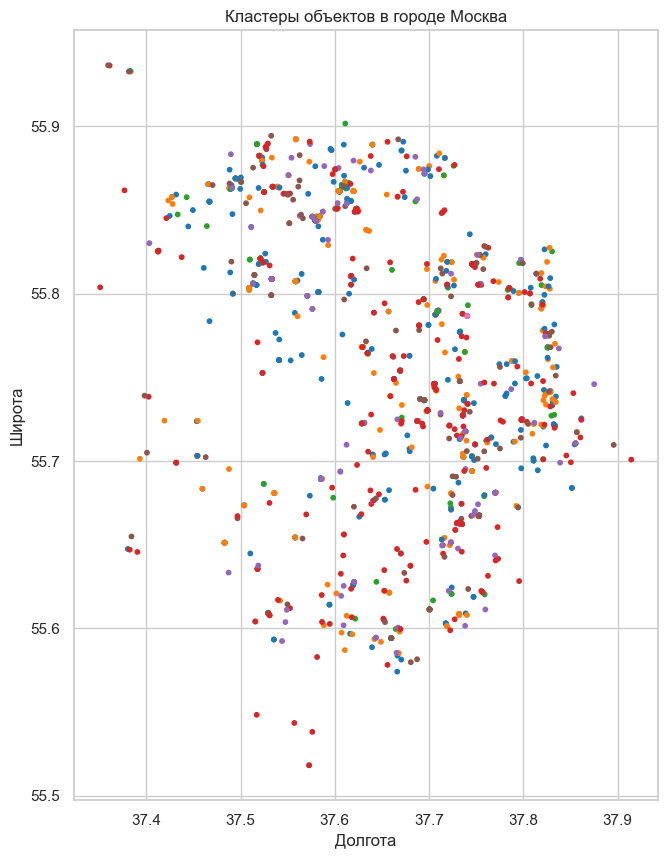

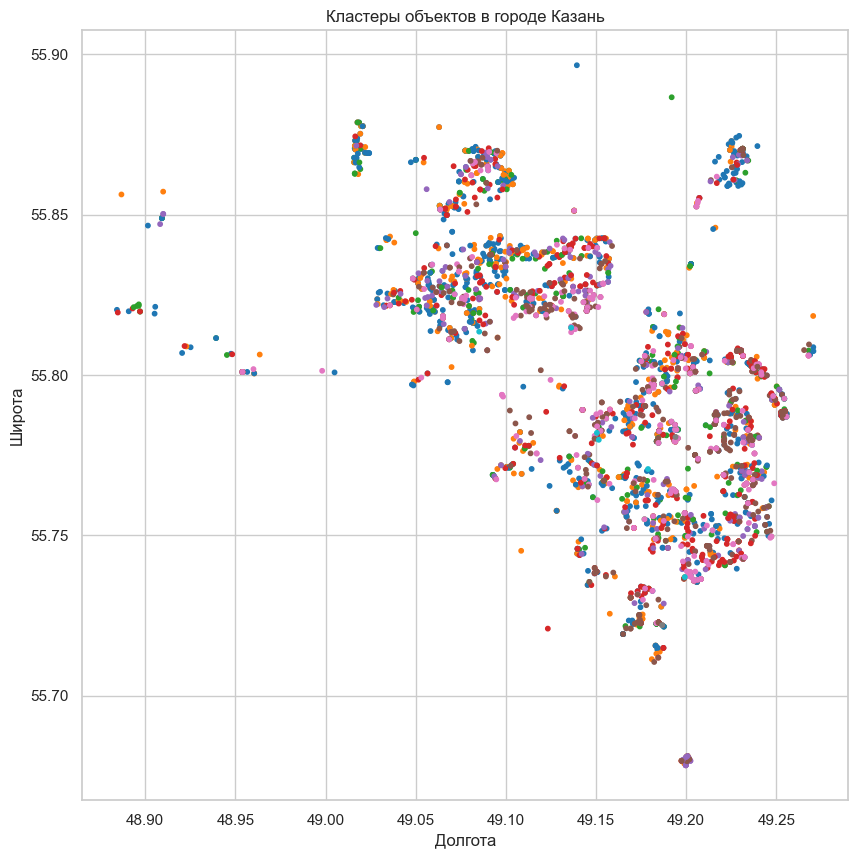

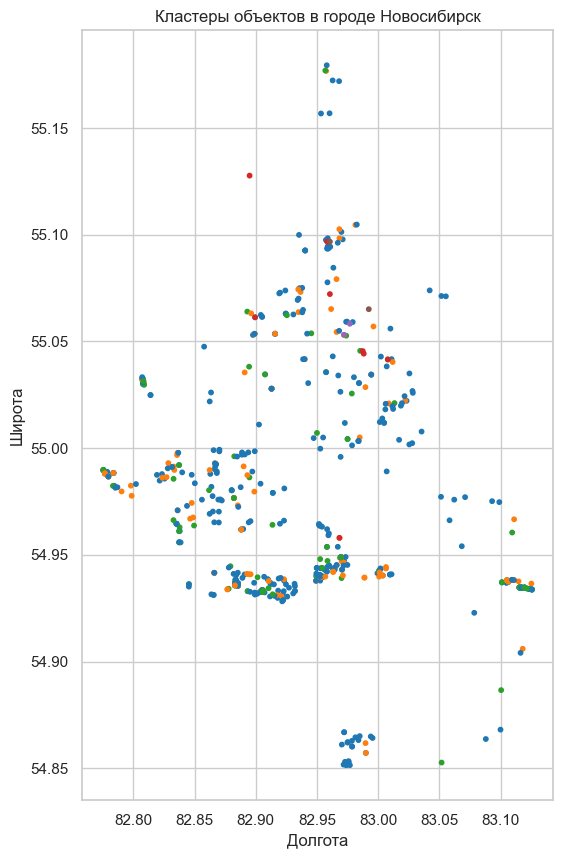

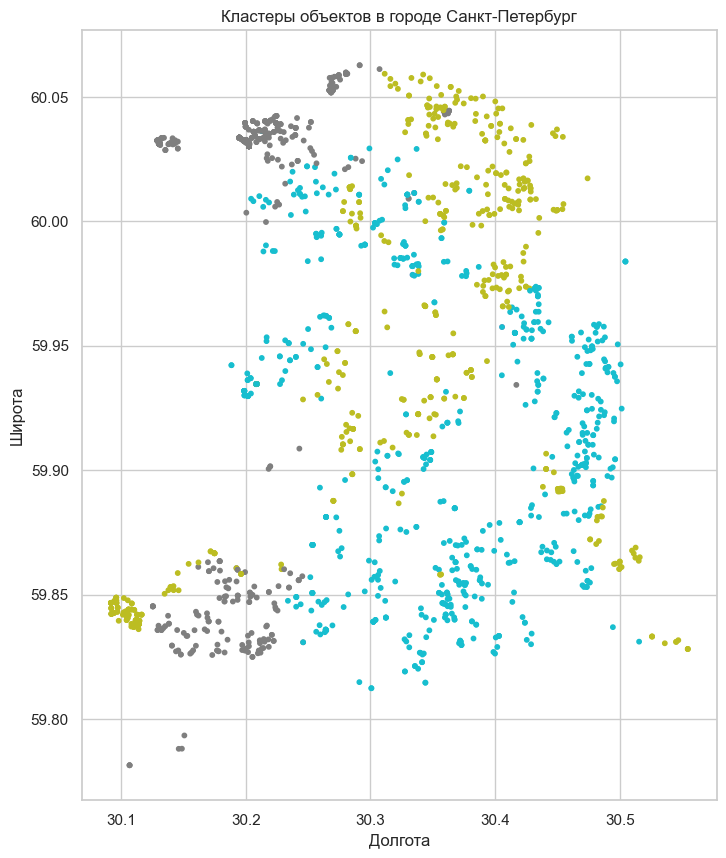

In [185]:
# Преобразуем DataFrame в GeoDataFrame для удобства работы с географическими данными
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = "EPSG:4326"  # WGS 84 - стандартная система координат для GPS

# Список городов для отображения
selected_cities = ['Москва', 'Казань', 'Новосибирск', 'Санкт-Петербург']

# Разделим на GeoDataFrames по городам для отдельных визуализаций
gdf_cities = {}
for city in gdf['city'].unique():
    gdf_cities[city] = gdf[gdf['city'] == city]

# Визуализация кластеров для выбранных городов
for city in selected_cities:
    if city in gdf_cities:
        city_gdf = gdf_cities[city]
        fig, ax = plt.subplots(figsize=(10, 10))
        city_gdf.plot(column='cluster', categorical=True, legend=False, markersize=10, ax=ax)
        ax.set_title(f'Кластеры объектов в городе {city}')
        ax.set_xlabel('Долгота')
        ax.set_ylabel('Широта')
        plt.show()

Проверим влияет ли на цену жилого помещения, тот факт является оно квартирой или нет

In [186]:
# Вызов функции для теста по 'is_apartment'
statistic, p_value = kruskal_wallis_test(df, 'is_apartment')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 1199.5078
P-значение: 7.803154621418287e-263


Можно заметить сильную статистическую значимость. Сравним визуально эту разницу.

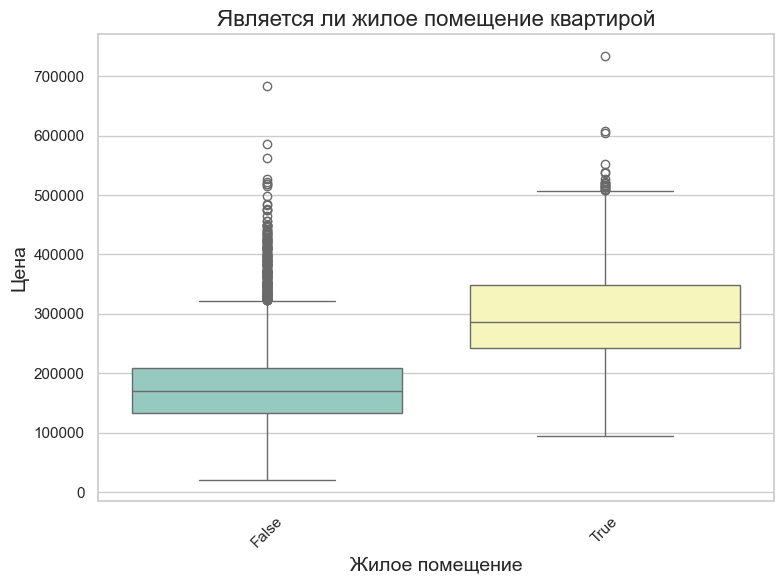

In [187]:
plot_price_by_category(
    df=df,
    cat_col='is_apartment',
    price_col='price_sq',
    title='Является ли жилое помещение квартирой',
    xlabel='Жилое помещение',
    palette='Set3'
)

Метрики качества модели:
accuracy_score: 0.9457
f1_score: 0.8210
precision_score: 0.8313
recall_score: 0.8110


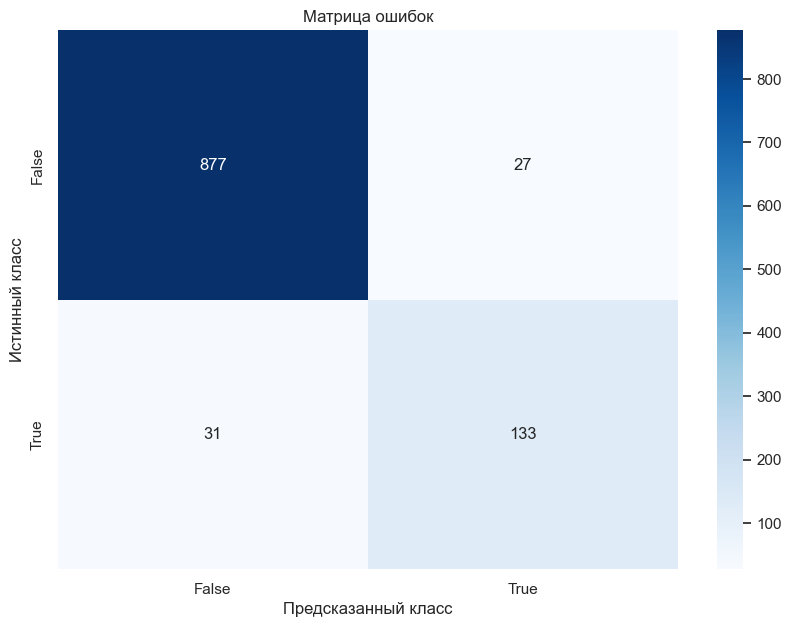

Пропущенные значения в колонке 'is_apartment' успешно заполнены с помощью модели.


In [188]:
# Фильтрация данных: оставляем observed значения для is_apartment (бинарный: 0/1)
df_model = df[df['is_apartment'].notna()].copy()

# Required columns: features + target
required_columns = ['is_apartment', 'build_year', 'city', 'house_wall_type', 'rooms', 'area', 'lat', 'lon']

# Удалим пропуски
df_model = df_model.dropna(subset=required_columns)

# Разделим данные на признаки и целевую переменную
features = ['build_year', 'city', 'house_wall_type', 'rooms', 'area', 'lat', 'lon']
target = 'is_apartment'
categorical_features = ['city', 'house_wall_type']

# CatBoostClassifier
model = CatBoostClassifier(
    verbose=False
)

metric_funcs = [accuracy_score, f1_score, precision_score, recall_score]
metric_averages = {'f1_score': 'binary', 'precision_score': 'binary', 'recall_score': 'binary'}

# Обучение
trained_model, y_pred, metrics = train_evaluate_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=model,
    metric_funcs=metric_funcs,
    categorical_features=categorical_features,
    metric_averages=metric_averages
)

# Заполнение пропусков
df = fill_missing_with_model(df, trained_model, features, target)

In [189]:
statistic, p_value = kruskal_wallis_test(df, 'has_gas')

print(f"Статистика Краскела-Уоллиса: {statistic:.4f}")
print(f"P-значение: {p_value}")

Статистика Краскела-Уоллиса: 138.2224
P-значение: 6.515398279654132e-32


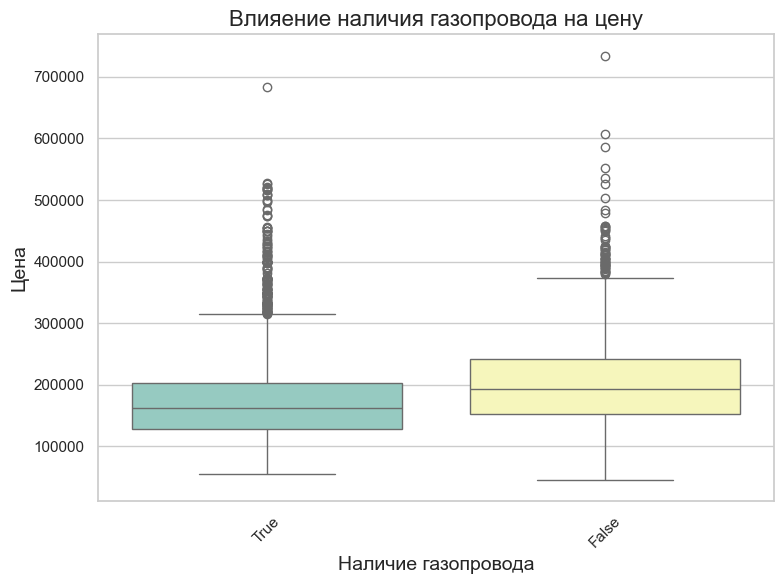

In [190]:
plot_price_by_category(
    df=df,
    cat_col='has_gas',
    price_col='price_sq',
    title='Влияение наличия газопровода на цену',
    xlabel='Наличие газопровода',
    palette='Set3'
)

Видно влияние на цену наличие газопровода, также создадим модель и посмотрим на ее качество прежде чем заполнять пропуски.

Метрики качества модели:
accuracy_score: 0.9118
f1_score: 0.9341
precision_score: 0.9358
recall_score: 0.9325


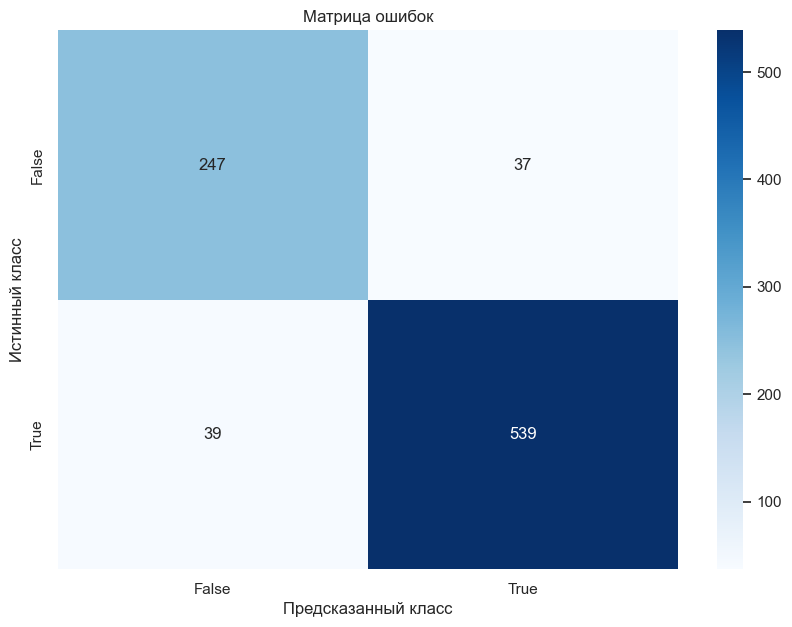

Пропущенные значения в колонке 'has_gas' успешно заполнены с помощью модели.


In [191]:
# Фильтрация данных: оставляем observed значения для has_gas (бинарный: True/False)
df_model = df[df['has_gas'].notna()].copy()

# Required columns: features + target
required_columns = ['has_gas', 'build_year', 'city', 'house_wall_type', 'lat', 'lon', 'area', 'rooms']

# Удалим пропуски
df_model = df_model.dropna(subset=required_columns)

# Разделим данные на признаки и целевую переменную
features = ['build_year', 'city', 'house_wall_type', 'lat', 'lon', 'area', 'rooms']
target = 'has_gas'
categorical_features = ['city', 'house_wall_type']

# CatBoostClassifier
model = CatBoostClassifier(
    verbose=False
)

metric_funcs = [accuracy_score, f1_score, precision_score, recall_score]
metric_averages = {'f1_score': 'binary', 'precision_score': 'binary', 'recall_score': 'binary'}

# Обучение
trained_model, y_pred, metrics = train_evaluate_model(
    df=df_model,
    features=features,
    target=target,
    ml_method=model,
    metric_funcs=metric_funcs,
    categorical_features=categorical_features,
    metric_averages=metric_averages
)


# Заполнение пропусков
df = fill_missing_with_model(df, trained_model, features, target)

Ввиду множественных сравнений, необходимо сделать поправку Бонферонни

In [192]:
# Kruskal-Wallis
# Spearman: price_sq-area (общий)
p_values = [
    1.656921374221397e-24,  # is_owner
    2.32730498918063e-214,   # loggia
    0.0004169376798542826,  # garage_type
    3.9551484032430166e-16, # years_ownership
    3.919080950208081e-05,  # owner_minors
    0.26924551422649834,    # garbage_disposer
    0.8673699484544827,     # redevelopment
    4.3918001507382945e-27, # bathroom_type
    3.4902617807461333e-78, # renovation
    7.55492430468964e-46,   # time_on_foot_to_subway
    7.803154621418287e-263, # is_apartment
    0.0000                  # Spearman price_sq-area
]

# Применение Bonferroni 
n_tests = len(p_values)
p_adjusted = [p * n_tests for p in p_values]

# Используем multipletests для Bonferroni
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Таблица результатов
results_df = pd.DataFrame({
    'Test': ['is_owner', 'loggia', 'garage_type', 'years_ownership', 'owner_minors', 'garbage_disposer', 'redevelopment', 'bathroom_type','renovation', 'time_on_foot_to_subway', 'is_apartment', 'Spearman area-price_sq'],
    'Original p-value': p_values,
    'Adjusted p-value (Bonferroni)': p_corrected,
    'Significant after correction': rejected
})

print("Таблица с поправкой на множественные сравнения (Bonferroni):")
print(results_df.round(6))

# Интерпретация
significant_tests = results_df[results_df['Significant after correction'] == True]['Test'].tolist()
print(f"\nЗначимые тесты после коррекции: {', '.join(significant_tests)}")
print(f"Из {n_tests} тестов {len(significant_tests)} остались значимыми (p_adj < 0.05).")

Таблица с поправкой на множественные сравнения (Bonferroni):
                      Test  Original p-value  Adjusted p-value (Bonferroni)  \
0                 is_owner          0.000000                       0.000000   
1                   loggia          0.000000                       0.000000   
2              garage_type          0.000417                       0.005003   
3          years_ownership          0.000000                       0.000000   
4             owner_minors          0.000039                       0.000470   
5         garbage_disposer          0.269246                       1.000000   
6            redevelopment          0.867370                       1.000000   
7            bathroom_type          0.000000                       0.000000   
8               renovation          0.000000                       0.000000   
9   time_on_foot_to_subway          0.000000                       0.000000   
10            is_apartment          0.000000                       0.0

В целом несмотря на множественные сравнения почти все p_value все равно остаются значимыми, кроме тех которые нами и так были признаны как незначимые.

Столбцы offer_views и id не несут никакой информации, кроме того исключим столбцы в которых много пропусков и противоречивые данные, в дальнейшем они нам не понадобятся.

In [193]:
columns_to_drop = [
    "offer_views",
    "id",
    "all_data.is_auction",
    "all_data.object_info.window_view[0].display_name",
    "all_data.object_info.window_view[1].display_name",
    "all_data.object_info.window_view[2].display_name",
    "all_data.object_info.window_view[3].display_name",
    "all_data.object_info.window_view[4].display_name",
    "all_data.legal_options.mortgage",
    "all_data.legal_options.is_individual",
    "all_data.legal_options.owner_minors",
    "all_data.legal_options.residence_minors",
    "all_data.house.security[0].display_name",
    "all_data.house.security[1].display_name",
    "all_data.house.security[2].display_name",
    "all_data.house.security[3].display_name",
    "all_data.house.parking[0].display_name",
    "all_data.house.parking[1].display_name",
    "all_data.house.parking[2].display_name",
    "all_data.house.parking[3].display_name",
    "all_data.house.parking[4].display_name",
    "all_data.house.yard[0].display_name",
    "all_data.house.yard[1].display_name",
    "all_data.house.infrastructure[0].display_name",
    "all_data.house.infrastructure[1].display_name",
    "all_data.house.infrastructure[2].display_name",
    "all_data.house.infrastructure[3].display_name",
    "all_data.house.infrastructure[4].display_name",
    "all_data.legal_options.years_ownership.display_name",
    "all_data.object_info.loggias",
    "all_data.house.ceiling_height",
    "all_data.legal_options.owner_count",
    "all_data.object_info.redevelopment",
    "all_data.house.has_garbage_disposer",
    "all_data.object_info.living_area",
    "all_data.legal_options.is_owner",
    "renovation",
    "sale_type"
]

df = df.drop(columns=columns_to_drop)


Напишем функцию и класс принимающие модели, обучающие их и проверяющие метрики этих моделей во избежание дублирования кода.

In [195]:
# identity-препроцессор (ничего не делает, нужен для единого интерфейса)
class IdentityTransformer:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X
    def fit_transform(self, X, y=None):
        return X

def run_any_regression_model(
    model,
    df,
    features,
    target,
    categorical_features,
    *,
    encoding='auto',               # 'auto' | 'ohe' | 'native'
    test_size=0.2,
    random_state=42,
    force_dense=False,             # для OHE: True — модели, не умеющие sparse
    ohe_params=None,               # доп. параметры для OHE (min_frequency, handle_unknown, max_categories...)
    compute_importance=True,
    importance_metric='mae',       # 'mae' | 'rmse' | 'mape'
    n_repeats=7,
    plot_importance=True,
    model_name=None,
    fit_params=None,
    train_fn=None,                 # кастомный тренер: train_fn(model, X_train_enc, y_train, X_valid_enc, y_valid)
    predict_fn=None                # кастомный предиктор: predict_fn(fitted_model, X_enc)
):
    """
    Универсальная обертка:
    - encoding='ohe' — OneHotEncoder только для категориальных, остальные фичи passthrough.
    - encoding='native' — без кодирования; для CatBoost автоматически передаст cat_features.
    - encoding='auto' — если модель CatBoost -> 'native', иначе 'ohe'.
    - Никакой импутации/скейлинга; считаем, что df готов.
    """

    # Подмножество колонок, реально присутствующих в df
    features_in_df = [c for c in features if c in df.columns]
    X = df[features_in_df]
    y = df[target]

    # Категориальные, реально присутствующие
    cat_cols = [c for c in categorical_features if c in features_in_df]

    # Разбиение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Определяем тип модели (CatBoost?) для auto-режима
    is_catboost = 'catboost' in str(type(model)).lower()

    if encoding == 'auto':
        encoding_mode = 'native' if is_catboost else 'ohe'
    else:
        encoding_mode = encoding

    # Готовим препроцессор
    if encoding_mode == 'ohe':
        base_ohe_kwargs = dict(handle_unknown='ignore', drop='if_binary', dtype=np.float32)
        if ohe_params:
            base_ohe_kwargs.update(ohe_params)

        # Совместимость со старыми/новыми версиями sklearn
        def make_ohe(force_dense_flag):
            try:
                return OneHotEncoder(sparse_output=not force_dense_flag, **base_ohe_kwargs)  # sklearn >=1.2
            except TypeError:
                return OneHotEncoder(sparse=not force_dense_flag, **base_ohe_kwargs)         # sklearn <1.2

        ohe = make_ohe(force_dense)
        preprocessor = ColumnTransformer(
            transformers=[('cat', ohe, cat_cols)],
            remainder='passthrough'
        )
    else:
        preprocessor = IdentityTransformer()

    # fit/transform препроцессора
    preprocessor.fit(X_train)
    X_train_enc = preprocessor.transform(X_train)
    X_test_enc = preprocessor.transform(X_test)

    # Для моделей, не умеющих sparse (актуально только для OHE)
    if encoding_mode == 'ohe' and force_dense and hasattr(X_train_enc, 'toarray'):
        X_train_enc = X_train_enc.toarray()
        X_test_enc = X_test_enc.toarray()

    # Обучение
    if fit_params is None:
        fit_params = {}

    fitted_model = None
    if train_fn is not None:
        fitted_model = train_fn(model, X_train_enc, y_train, X_test_enc, y_test)
    else:
        # Пытаемся задать random_state, если поддерживается
        try:
            if random_state is not None and hasattr(model, "get_params") and 'random_state' in model.get_params():
                model.set_params(random_state=random_state)
        except Exception:
            pass

        # Спец-ветка для CatBoost с нативными категориальными
        if is_catboost and encoding_mode != 'ohe':
            # cat_features — индексы категориальных в порядке features_in_df
            cat_idx = [features_in_df.index(c) for c in cat_cols]
            if hasattr(model, 'fit'):
                fitted_model = model.fit(X_train, y_train, cat_features=cat_idx, **fit_params)
            else:
                raise ValueError("У переданной CatBoost-модели нет .fit")
        else:
            # Обычное .fit для остальных случаев
            if hasattr(model, 'fit'):
                fitted_model = model.fit(X_train_enc, y_train, **fit_params)
            else:
                raise ValueError("Ни train_fn не передан, ни .fit у модели нет — не знаю, как обучать.")

    # Предсказания
    if predict_fn is not None:
        y_pred = predict_fn(fitted_model, X_test_enc)
    else:
        if not hasattr(fitted_model, 'predict'):
            raise ValueError("predict_fn не передан, и у модели нет .predict — не знаю, как предсказывать.")
        # Для CatBoost + native используем исходный X_test (без OHE)
        if is_catboost and encoding_mode != 'ohe':
            y_pred = fitted_model.predict(X_test)
        else:
            y_pred = fitted_model.predict(X_test_enc)

    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    name = model_name or model.__class__.__name__
    print(f"Метрики ({name}, encoding={encoding_mode}):")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # OOB (если есть)
    oob = None
    if hasattr(fitted_model, 'oob_score_'):
        try:
            oob = fitted_model.oob_score_
            print(f"OOB R² (out-of-bag): {oob:.4f}")
        except Exception:
            pass

    # Permutation importance по исходным признакам
    importance_df = None
    if compute_importance:
        def metric_func(y_true, y_hat, metric):
            if metric == 'mae':
                return mean_absolute_error(y_true, y_hat)
            elif metric == 'rmse':
                return float(np.sqrt(mean_squared_error(y_true, y_hat)))
            elif metric == 'mape':
                return mean_absolute_percentage_error(y_true, y_hat)
            else:
                raise ValueError("importance_metric должен быть 'mae' | 'rmse' | 'mape'")

        baseline = metric_func(y_test, y_pred, importance_metric)
        rng = np.random.default_rng(random_state)

        importances = []
        for col in features_in_df:
            scores = []
            for _ in range(n_repeats):
                X_shuffled = X_test.copy()
                X_shuffled[col] = rng.permutation(X_shuffled[col].values)

                if encoding_mode == 'ohe':
                    X_shuf_enc = preprocessor.transform(X_shuffled)
                    if force_dense and hasattr(X_shuf_enc, 'toarray'):
                        X_shuf_enc = X_shuf_enc.toarray()
                    y_shuf_pred = predict_fn(fitted_model, X_shuf_enc) if predict_fn else fitted_model.predict(X_shuf_enc)
                else:
                    y_shuf_pred = predict_fn(fitted_model, X_shuffled) if predict_fn else fitted_model.predict(X_shuffled)

                score = metric_func(y_test, y_shuf_pred, importance_metric)
                scores.append(score - baseline)  # рост ошибки => важность
            importances.append((col, float(np.mean(scores)), float(np.std(scores))))

        importance_df = pd.DataFrame(importances, columns=['Feature', 'Importance', 'Std']) \
                           .sort_values('Importance', ascending=False)

        print("\nТоп-10 признаков по важности (Permutation, рост ошибки):")
        print(importance_df.head(10).round(4))

        if plot_importance and not importance_df.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', color='#4C72B0')
            plt.title(f'Permutation Importance (metric: {importance_metric}) — {name}')
            plt.xlabel('Δ ошибка (выше = важнее)')
            plt.ylabel('Признак')
            plt.tight_layout()
            plt.show()

    return {
        'preprocessor': preprocessor,
        'model': fitted_model,
        'encoding': encoding_mode,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'X_train_enc': X_train_enc if encoding_mode == 'ohe' else None,
        'X_test_enc': X_test_enc if encoding_mode == 'ohe' else None,
        'y_pred': y_pred,
        'metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'OOB_R2': oob},
        'importance': importance_df
    }

Реализуем многослойный персептрон через PyTorch как одну из моделей.

In [196]:
# ============================ PyTorch tabular regressor ============================
from dataclasses import dataclass
from typing import Dict, List, Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# --------- Конфиг ----------
@dataclass
class TorchConfig:
    hidden_dim: int = 256
    n_blocks: int = 4
    dropout: float = 0.15
    emb_dropout: float = 0.05
    lr: float = 1e-3
    weight_decay: float = 1e-4
    batch_size: int = 512
    epochs: int = 200
    patience: int = 20
    cat_min_freq: int = 20         # реже -> в UNK
    use_log_target: bool = True
    seed: int = 42
    # можно тюнинговать: activation='gelu'|'relu', loss='mse'|'huber', etc.

# --------- Фиксация сидов ----------
def set_global_seed(seed: int = 42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --------- Препроцессор табличных данных ----------
class TorchPreprocessor:
    def __init__(self, cat_cols: List[str], num_cols: List[str], cat_min_freq: int = 20, use_log_target: bool = True):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.cat_min_freq = cat_min_freq
        self.use_log_target = use_log_target

        self.cat_maps: Dict[str, Dict[str, int]] = {}
        self.num_means: Dict[str, float] = {}
        self.num_stds: Dict[str, float] = {}

    def fit(self, df: pd.DataFrame, y: pd.Series):
        # Категории: частоты -> маппинги
        for col in self.cat_cols:
            vc = df[col].astype('object').value_counts(dropna=False)
            kept = vc[vc >= self.cat_min_freq].index.tolist()
            # 0 — UNK; реальные категории начинаются с 1
            mapping = {str(cat): i+1 for i, cat in enumerate(kept)}
            self.cat_maps[col] = mapping

        # Численные: медиана/среднее и std
        for col in self.num_cols:
            x = pd.to_numeric(df[col], errors='coerce')
            m = float(x.mean(skipna=True))
            s = float(x.std(skipna=True))
            if not np.isfinite(s) or s == 0.0:
                s = 1.0
            self.num_means[col] = m
            self.num_stds[col] = s

        # Ничего специального с y тут не делаем, только флаг use_log_target

    def _transform_X(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        # Категориальные -> индексы
        X_cat = []
        for col in self.cat_cols:
            mapping = self.cat_maps[col]
            vals = df[col].astype('object').map(lambda v: mapping.get(str(v), 0)).astype(np.int64).values
            X_cat.append(vals)
        X_cat = np.stack(X_cat, axis=1) if len(self.cat_cols) > 0 else np.zeros((len(df), 0), dtype=np.int64)

        # Численные -> стандартизация
        X_num = []
        for col in self.num_cols:
            x = pd.to_numeric(df[col], errors='coerce').fillna(self.num_means[col]).values.astype(np.float32)
            x = (x - self.num_means[col]) / self.num_stds[col]
            X_num.append(x)
        X_num = np.stack(X_num, axis=1).astype(np.float32) if len(self.num_cols) > 0 else np.zeros((len(df), 0), dtype=np.float32)
        return X_num, X_cat

    def transform_X(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        return self._transform_X(df)

    def transform_y(self, y: pd.Series) -> np.ndarray:
        y = y.values.astype(np.float32)
        if self.use_log_target:
            y = np.log1p(np.clip(y, a_min=0, a_max=None))
        return y

    def inverse_y(self, y_pred: np.ndarray) -> np.ndarray:
        if self.use_log_target:
            y_pred = np.expm1(y_pred)
        return y_pred

    def cat_cardinalities(self) -> List[int]:
        # num_embeddings для каждого столбца (включая UNK)
        return [len(m) + 1 for m in self.cat_maps.values()]

# --------- Датасет ----------
class TabDataset(Dataset):
    def __init__(self, X_num: np.ndarray, X_cat: np.ndarray, y: np.ndarray = None):
        self.X_num = torch.from_numpy(X_num) if isinstance(X_num, np.ndarray) else X_num
        self.X_cat = torch.from_numpy(X_cat) if isinstance(X_cat, np.ndarray) else X_cat
        self.y = torch.from_numpy(y).view(-1, 1) if y is not None else None

    def __len__(self):
        return self.X_num.size(0)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X_num[idx], self.X_cat[idx]
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

# --------- Модель ----------
def emb_dim_rule(n_cat: int) -> int:
    # эвристика fastai-like
    return int(min(32, max(4, round(1.6 * (n_cat ** 0.56)))))

class ResidualBlock(nn.Module):
    def __init__(self, dim: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return x + self.net(x)

class TabularNN(nn.Module):
    def __init__(self, cat_cardinalities: List[int], num_dim: int, cfg: TorchConfig):
        super().__init__()
        self.cfg = cfg
        self.has_cats = len(cat_cardinalities) > 0
        self.has_nums = num_dim > 0

        if self.has_cats:
            self.embs = nn.ModuleList([nn.Embedding(num_embeddings=c, embedding_dim=emb_dim_rule(c), padding_idx=0)
                                       for c in cat_cardinalities])
            self.emb_dropout = nn.Dropout(cfg.emb_dropout)
            emb_total = sum(e.embedding_dim for e in self.embs)
        else:
            self.embs = nn.ModuleList()
            self.emb_dropout = nn.Dropout(0.0)
            emb_total = 0

        self.num_bn = nn.BatchNorm1d(num_dim) if self.has_nums else nn.Identity()

        in_dim = emb_total + (num_dim if self.has_nums else 0)
        hid = cfg.hidden_dim

        self.input = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.BatchNorm1d(hid),
            nn.GELU(),
            nn.Dropout(cfg.dropout)
        )
        self.blocks = nn.Sequential(*[ResidualBlock(hid, cfg.dropout) for _ in range(cfg.n_blocks)])
        self.head = nn.Linear(hid, 1)

    def forward(self, x_num: torch.Tensor, x_cat: torch.Tensor):
        parts = []
        if self.has_cats and x_cat.numel() > 0:
            emb_list = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)]
            x_emb = torch.cat(emb_list, dim=1)
            x_emb = self.emb_dropout(x_emb)
            parts.append(x_emb)
        if self.has_nums and x_num.numel() > 0:
            parts.append(self.num_bn(x_num))
        x = torch.cat(parts, dim=1) if len(parts) > 1 else parts[0]
        x = self.input(x)
        x = self.blocks(x)
        out = self.head(x)
        return out

# --------- Тренировка / Предсказание ----------
class FittedTorchModel:
    def __init__(self, net: nn.Module, preproc: TorchPreprocessor, device: torch.device):
        self.net = net
        self.preproc = preproc
        self.device = device

def train_torch(model_cfg: TorchConfig, X_train: pd.DataFrame, y_train: pd.Series,
                X_valid: pd.DataFrame, y_valid: pd.Series) -> FittedTorchModel:
    set_global_seed(model_cfg.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_cols = list(X_train.columns)
    cat_cols = [c for c in all_cols if c in categorical_features_declared]
    num_cols = [c for c in all_cols if c not in cat_cols]

    pre = TorchPreprocessor(cat_cols, num_cols,
                            cat_min_freq=model_cfg.cat_min_freq,
                            use_log_target=model_cfg.use_log_target)
    pre.fit(X_train, y_train)

    Xtr_num, Xtr_cat = pre.transform_X(X_train)
    Xva_num, Xva_cat = pre.transform_X(X_valid)
    ytr = pre.transform_y(y_train)
    yva = pre.transform_y(y_valid)

    train_ds = TabDataset(Xtr_num, Xtr_cat, ytr)
    valid_ds = TabDataset(Xva_num, Xva_cat, yva)

    pin = device.type == 'cuda'
    train_loader = DataLoader(train_ds, batch_size=model_cfg.batch_size, shuffle=True, drop_last=False, num_workers=0, pin_memory=pin)
    valid_loader = DataLoader(valid_ds, batch_size=2048, shuffle=False, drop_last=False, num_workers=0, pin_memory=pin)

    net = TabularNN(pre.cat_cardinalities(), num_dim=Xtr_num.shape[1], cfg=model_cfg).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=model_cfg.lr, weight_decay=model_cfg.weight_decay)

    # FIX: без verbose для совместимости со старыми версиями torch
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    best_rmse = float('inf')
    best_state = None
    patience_left = model_cfg.patience

    for epoch in range(model_cfg.epochs):
        net.train()
        for xb_num, xb_cat, yb in train_loader:
            xb_num = xb_num.to(device)
            xb_cat = xb_cat.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            preds = net(xb_num, xb_cat)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        net.eval()
        val_losses = []
        with torch.no_grad():
            for xb_num, xb_cat, yb in valid_loader:
                xb_num = xb_num.to(device)
                xb_cat = xb_cat.to(device)
                yb = yb.to(device)
                preds = net(xb_num, xb_cat)
                val_losses.append(criterion(preds, yb).item())
        val_mse = float(np.mean(val_losses))
        val_rmse = float(np.sqrt(val_mse))
        scheduler.step(val_rmse)

        if val_rmse + 1e-6 < best_rmse:
            best_rmse = val_rmse
            best_state = {k: v.cpu().clone() for k, v in net.state_dict().items()}
            patience_left = model_cfg.patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    if best_state is not None:
        net.load_state_dict(best_state)

    return FittedTorchModel(net=net, preproc=pre, device=device)

def predict_torch(fitted: FittedTorchModel, X: pd.DataFrame) -> np.ndarray:
    fitted.net.eval()
    X_num, X_cat = fitted.preproc.transform_X(X)
    ds = TabDataset(X_num, X_cat, y=None)
    loader = DataLoader(ds, batch_size=4096, shuffle=False)

    preds = []
    with torch.no_grad():
        for xb_num, xb_cat in loader:
            xb_num = xb_num.to(fitted.device)
            xb_cat = xb_cat.to(fitted.device)
            out = fitted.net(xb_num, xb_cat).cpu().numpy().reshape(-1)
            preds.append(out)
    preds = np.concatenate(preds, axis=0)
    preds = fitted.preproc.inverse_y(preds)
    return preds
# ============================ /PyTorch tabular regressor ============================

Попробуем различные бустинги, такие как LightGMB, CatBoost, XGBoost, а также регрессию Лассо с многослойным персептроном для обучения модели предсказывающей цену на жилплощадь.

In [197]:
# Ваши списки признаков
features_final = [
    'city', 'lat', 'lon', 'area', 'floor', 'kitchen_area', 'bathroom_type', 'balconies',
    'is_apartment', 'rooms', 'house_floors', 'house_wall_type', 'lifts', 'freight_lifts',
    'time_on_foot_to_subway', 'build_year', 'has_gas', 'urgent', 'duplicates_count',
    'is_auction', 'all_data.legal_options.approve',
    'all_data.object_info.garage_type.display_name', 'cluster'
]
target_final = 'price_sq'

categorical_features_declared = [
    'city',
    'bathroom_type',
    'is_apartment',
    'house_wall_type',
    'has_gas',
    'all_data.object_info.garage_type.display_name',
    'cluster'
]


res_rf = run_any_regression_model(
    model=RandomForestRegressor(
        n_estimators=600, bootstrap=True, oob_score=False,  
        n_jobs=-1, random_state=42
    ),
    df=df,
    features=features_final,
    target=target_final,
    categorical_features=categorical_features_declared,
    encoding='ohe',
    compute_importance=False
)


res_cat = run_any_regression_model(
    model=CatBoostRegressor(
        depth=8, learning_rate=0.05, iterations=1000,
        loss_function='RMSE', verbose=False, random_state=42
    ),
    df=df,
    features=features_final,
    target=target_final,
    categorical_features=categorical_features_declared,
    encoding='native',
    compute_importance=False
)


res_xgb = run_any_regression_model(
    model=XGBRegressor(
        n_estimators=800, max_depth=8, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, tree_method='hist',
        n_jobs=-1, random_state=42, verbosity=0  
    ),
    df=df,
    features=features_final,
    target=target_final,
    categorical_features=categorical_features_declared,
    encoding='ohe',
    compute_importance=False
)


res_lgb = run_any_regression_model(
    model=LGBMRegressor(
        n_estimators=1200, learning_rate=0.05, num_leaves=64,
        subsample=0.9, colsample_bytree=0.8, n_jobs=-1, random_state=42,
        verbosity=-1,  # глушим инфо-логи
        verbose=-1,
        force_row_wise=True 
    ),
    df=df,
    features=features_final,
    target=target_final,
    categorical_features=categorical_features_declared,
    encoding='ohe',
    compute_importance=False,
    fit_params={'callbacks': [lgb.log_evaluation(0)]}  # глушим eval-лог
)

res_ridge = run_any_regression_model(
    model=Ridge(alpha=10.0),
    df=df,
    features=features_final,
    target=target_final,
    categorical_features=categorical_features_declared,
    encoding='ohe',
    compute_importance=False
)


# Запуск PyTorch модели
torch_cfg = TorchConfig(
    hidden_dim=256,
    n_blocks=4,
    dropout=0.15,
    emb_dropout=0.05,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=512,
    epochs=200,
    patience=20,
    cat_min_freq=20,
    use_log_target=True,
    seed=42
)

res_torch = run_any_regression_model(
    model=torch_cfg,
    df=df,
    features=features_final,
    target=target_final,
    categorical_features=categorical_features_declared,
    encoding='native',           # важно: передадим DataFrame без OHE
    compute_importance=False,    # только метрики
    train_fn=train_torch,        # кастомный тренер
    predict_fn=predict_torch     # кастомный предиктор (возвращает в исходном масштабе)
)



# Добавим в сводку
summary = pd.DataFrame([
    {'Model': 'RandomForest (OHE)', **res_rf['metrics']},
    {'Model': 'CatBoost (native)', **res_cat['metrics']},
    {'Model': 'XGBRegressor (OHE)', **res_xgb['metrics']},
    {'Model': 'LightGBM (OHE)', **res_lgb['metrics']},
    {'Model': 'Ridge (OHE)', **res_ridge['metrics']},
    {'Model': 'PyTorch MLP (embeddings)', **res_torch['metrics']},
]).round(4)

print("\nСводка по моделям:")
print(summary[['Model', 'MAE', 'RMSE', 'R2', 'MAPE']])

Метрики (RandomForestRegressor, encoding=ohe):
MAE:  15371.97
RMSE: 24088.38
R²:   0.9158
MAPE: 8.09%
Метрики (CatBoostRegressor, encoding=native):
MAE:  15282.31
RMSE: 23260.67
R²:   0.9215
MAPE: 7.99%
Метрики (XGBRegressor, encoding=ohe):
MAE:  14658.52
RMSE: 22649.92
R²:   0.9256
MAPE: 7.75%
Метрики (LGBMRegressor, encoding=ohe):
MAE:  15001.28
RMSE: 22588.34
R²:   0.9260
MAPE: 7.97%
Метрики (Ridge, encoding=ohe):
MAE:  27560.44
RMSE: 40112.05
R²:   0.7666
MAPE: 14.21%
Метрики (TorchConfig, encoding=native):
MAE:  28985.82
RMSE: 43424.94
R²:   0.7265
MAPE: 13.67%

Сводка по моделям:
                      Model         MAE        RMSE      R2     MAPE
0        RandomForest (OHE)  15371.9688  24088.3806  0.9158   8.0917
1         CatBoost (native)  15282.3114  23260.6713  0.9215   7.9904
2        XGBRegressor (OHE)  14658.5151  22649.9189  0.9256   7.7516
3            LightGBM (OHE)  15001.2758  22588.3420  0.9260   7.9668
4               Ridge (OHE)  27560.4399  40112.0482  0.7666  1

В целом видно, что лучше всего отработали бустинги, что в целом неудивительно так как они лучше всего работают с табличными данными, в то время как нейросети лучше справляются с данными со сложной стркутурой (текст, изображения и тд.) Лучше всего себя показала XGBRegressor, далее чуть уступает ей LightGBM. 

Найдем наилучшие гиперпараметры, дабы улучшить метрики. Воспользуемся для этого LightGBM в качестве модели и Optuna в качестве оптимизации гиперпараметров. LightGBM был выбран мной ввиду того что модель библиотека была специально написана под быстрое обучение и подбор гиперпараметров не займет много времени. Optuna же хорошо находит лучшие гиперпараметры в пространстве признаков. Будем оптимизировать по метрике R² используя среднее значение по 5 разбиеням датасета. 

In [102]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ---- Конфиг признаков ----
features_final = [
    'city', 'lat', 'lon', 'area', 'floor', 'kitchen_area', 'bathroom_type',
    'balconies', 'is_apartment', 'rooms', 'house_floors', 'house_wall_type',
    'lifts', 'freight_lifts', 'time_on_foot_to_subway', 'build_year', 'has_gas',
    'urgent', 'duplicates_count', 'is_auction', 'all_data.legal_options.approve',
    'all_data.object_info.garage_type.display_name', 'cluster'
]
target_final = 'price_sq'
categorical_features = [
    'city',
    'bathroom_type',
    'is_apartment',
    'house_wall_type',
    'has_gas',
    'all_data.object_info.garage_type.display_name',
    'cluster'
]

df_model_final = df.dropna(subset=features_final + [target_final]).copy()
for col in categorical_features:
    if col in df_model_final.columns:
        df_model_final[col] = df_model_final[col].astype('category')

X = df_model_final[features_final]
y = df_model_final[target_final]
cat_cols = [c for c in categorical_features if c in X.columns]

def make_ohe(cat_cols, min_freq=None, force_dense=False):
    base = dict(handle_unknown='ignore', drop=None, dtype=np.float32)
    if min_freq is not None:
        base['min_frequency'] = min_freq 
    try:
        ohe = OneHotEncoder(sparse_output=not force_dense, **base)  
    except TypeError:
        base.pop('min_frequency', None)
        ohe = OneHotEncoder(sparse=not force_dense, **base)
    pre = ColumnTransformer([('cat', ohe, cat_cols)], remainder='passthrough')
    return pre

def get_feature_names_robust(pre: ColumnTransformer, X_cols: list, cat_cols: list):
    try:
        return pre.get_feature_names_out()
    except Exception:
        ohe = pre.named_transformers_['cat']
        try:
            ohe_names = ohe.get_feature_names_out(cat_cols)
        except Exception:
            ohe_names = ohe.get_feature_names(cat_cols)
        rest = [c for c in X_cols if c not in cat_cols]
        return np.array([f'cat__{n}' for n in ohe_names] + [f'remainder__{c}' for c in rest], dtype=object)

def base_feature_name(feat_name: str, cat_cols: list):
    name = feat_name.split('__', 1)[1] if '__' in feat_name else feat_name
    for c in cat_cols:
        if name.startswith(c + "_"):
            return c
    return name

# ---- Настройки вывода ----
VERBOSE_FOLDS = False     # True — печать R² по фолдам
N_TRIALS = 150            # для печати "Trial i/N"

# ---- Callbacks для LGBM ----
def make_lgb_callbacks(stopping_rounds: int):
    cbs = []
    try:
        cbs.append(lgb.early_stopping(stopping_rounds, verbose=False))
    except TypeError:
        cbs.append(lgb.early_stopping(stopping_rounds))
    try:
        cbs.append(lgb.log_evaluation(period=0))  # глушим логи LGBM
    except TypeError:
        pass
    return cbs

def filter_lgbm_params(params: dict) -> dict:
    accepted = set(LGBMRegressor().get_params().keys())
    return {k: v for k, v in params.items() if k in accepted}

# Красивая короткая строка с параметрами
def params_summary(d: dict) -> str:
    order = [
        'boosting_type', 'learning_rate', 'n_estimators', 'num_leaves',
        'subsample', 'colsample_bytree', 'subsample_freq',
        'min_child_samples', 'min_child_weight', 'min_split_gain',
        'reg_alpha', 'reg_lambda', 'max_bin', 'ohe_min_freq'
    ]
    items = []
    for k in order:
        if k in d:
            v = d[k]
            if isinstance(v, float):
                v = round(v, 6 if k in ('learning_rate', 'min_child_weight') else 4)
            items.append(f"{k}={v}")
    return " | ".join(items)

# ---- Optuna objective ----
def objective(trial):
    # OHE: схлопываем редкие категории
    ohe_min_freq = trial.suggest_int('ohe_min_freq', 5, 100)

    # Тип бустинга
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])

    # Гиперпараметры LightGBM 
    params = {
        'boosting_type': boosting_type,
        'objective': 'regression',
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1,
        'force_row_wise': True,

        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000),

        'num_leaves': trial.suggest_int('num_leaves', 31, 511),
        'max_depth': -1,

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),

        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 20.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0, log=True),
        'max_bin': trial.suggest_int('max_bin', 127, 511),
    }

    # DART-специфика
    if boosting_type == 'dart':
        params.update({
            'drop_rate': trial.suggest_float('drop_rate', 0.0, 0.3),
            'skip_drop': trial.suggest_float('skip_drop', 0.0, 0.7),
        })

    # GOSS не совместим с bagging/subsample
    if boosting_type == 'goss':
        params['subsample'] = 1.0
        params['subsample_freq'] = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        pre = make_ohe(cat_cols, min_freq=ohe_min_freq, force_dense=False)
        X_tr_enc = pre.fit_transform(X_tr)
        X_val_enc = pre.transform(X_val)

        model = LGBMRegressor(**filter_lgbm_params(params))
        model.fit(
            X_tr_enc, y_tr,
            eval_set=[(X_val_enc, y_val)],
            eval_metric='rmse',
            callbacks=make_lgb_callbacks(stopping_rounds=100)
        )

        preds = model.predict(X_val_enc)
        r2 = r2_score(y_val, preds)
        scores.append(r2)

        if VERBOSE_FOLDS:
            print(f"Trial {trial.number+1:03d}/{N_TRIALS} | Fold {fold}/5 | R²_fold={r2:.4f} | R²_mean={np.mean(scores):.4f}")

        trial.report(np.mean(scores), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    trial.set_user_attr('cv_scores', scores)
    return float(np.mean(scores))

# ---- Callback для печати каждого трейла (без прогресс-бара) ----
def print_trial_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    try:
        best_val = f"{study.best_value:.5f}"
        best_num = study.best_trial.number
    except Exception:
        best_val, best_num = "NA", "NA"

    state = trial.state.name  # COMPLETE / PRUNED / FAIL
    val = trial.value
    val_str = f"{val:.5f}" if val is not None else "None"
    dur = str(trial.duration).split('.')[0] if trial.duration else "NA"

    print(f"[{state:>8}] Trial {trial.number+1:03d}/{N_TRIALS} | value={val_str} | best={best_val} (#{best_num}) | time={dur}")

    cv_scores = trial.user_attrs.get('cv_scores')
    if cv_scores:
        cv_str = " ".join(f"{s:.3f}" for s in cv_scores)
        print(f"           CV R²: [{cv_str}] -> mean={np.mean(cv_scores):.3f}")

    # Компактный вывод основных параметров
    merged = {**trial.params}
    print(f"           Params: {params_summary(merged)}")

# ---- Стартовый фиксированный трейл ----
base_trial = {
    'n_estimators': 1200,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'subsample': 0.9,          # alias bagging_fraction
    'colsample_bytree': 0.8,   # alias feature_fraction
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1,
    'force_row_wise': True   
}

# ---- Запуск Optuna ----
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)
study.enqueue_trial(base_trial)
# Выключаем стандартный прогресс-бар Optuna, чтобы вывод не съезжал
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False, callbacks=[print_trial_callback])

print("Лучшие параметры:")
print(study.best_params)
print(f"Лучший CV R²: {study.best_value:.4f}")

# ---- Hold-out ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# OHE с лучшим min_freq
best_ohe_min_freq = study.best_params.get('ohe_min_freq', None)
pre_final = make_ohe(cat_cols, min_freq=best_ohe_min_freq, force_dense=False)

X_train_enc = pre_final.fit_transform(X_train)
X_test_enc = pre_final.transform(X_test)

# Сбор финальных параметров, отфильтруем неподдерживаемые
best_params_raw = {
    **study.best_params,
    'objective': 'regression',
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1,
    'force_row_wise': True,  
}
best_params_lgb = filter_lgbm_params({k: v for k, v in best_params_raw.items() if k != 'ohe_min_freq'})

final_model = LGBMRegressor(**best_params_lgb)
final_model.fit(
    X_train_enc, y_train,
    eval_set=[(X_test_enc, y_test)],
    eval_metric='rmse',
    callbacks=make_lgb_callbacks(stopping_rounds=200)
)

# ---- Метрики ----
y_pred = final_model.predict(X_test_enc)
mae = mean_absolute_error(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2_test = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nМетрики на test set с оптимизированными параметрами:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2_test:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---- Importance агрегированная к исходным фичам ----
feat_names = get_feature_names_robust(pre_final, list(X.columns), cat_cols)
fi_arr = final_model.booster_.feature_importance(importance_type='gain')
ohe_imp = pd.DataFrame({'Feature_OHE': feat_names, 'Importance': fi_arr})
ohe_imp['BaseFeature'] = ohe_imp['Feature_OHE'].apply(lambda n: base_feature_name(n, cat_cols))
importance = (
    ohe_imp.groupby('BaseFeature', as_index=False)['Importance']
    .sum()
    .sort_values('Importance', ascending=False)
)
print("\nТоп-10 признаков по важности (агрегировано по исходным признакам):")
print(importance.head(10).round(4))

[COMPLETE] Trial 001/150 | value=0.91432 | best=0.91432 (#0) | time=0:00:06
           CV R²: [0.926 0.903 0.921 0.901 0.921] -> mean=0.914
           Params: boosting_type=gbdt | learning_rate=0.05 | n_estimators=1200 | num_leaves=64 | subsample=0.9 | colsample_bytree=0.8 | subsample_freq=2 | min_child_samples=35 | min_child_weight=0.001778 | min_split_gain=0.8662 | reg_alpha=0.0026 | reg_lambda=3.4703 | max_bin=134 | ohe_min_freq=40
[COMPLETE] Trial 002/150 | value=0.84196 | best=0.91432 (#0) | time=0:00:04
           CV R²: [0.856 0.841 0.843 0.824 0.846] -> mean=0.842
           Params: boosting_type=gbdt | learning_rate=0.002643 | n_estimators=817 | num_leaves=283 | subsample=0.7165 | colsample_bytree=0.7728 | subsample_freq=5 | min_child_samples=32 | min_child_weight=0.018052 | min_split_gain=0.3664 | reg_alpha=0.0001 | reg_lambda=8.431 | max_bin=203 | ohe_min_freq=98
[COMPLETE] Trial 003/150 | value=0.74940 | best=0.91432 (#0) | time=0:00:05
           CV R²: [0.756 0.748 0.759 

[COMPLETE] Trial 020/150 | value=0.91108 | best=0.91904 (#15) | time=0:01:14
           CV R²: [0.920 0.905 0.917 0.896 0.917] -> mean=0.911
           Params: boosting_type=dart | learning_rate=0.031717 | n_estimators=1465 | num_leaves=194 | subsample=0.9566 | colsample_bytree=0.6658 | subsample_freq=3 | min_child_samples=5 | min_child_weight=0.045666 | min_split_gain=0.7664 | reg_alpha=0.0005 | reg_lambda=0.0012 | max_bin=353 | ohe_min_freq=27
[  PRUNED] Trial 021/150 | value=0.84393 | best=0.91904 (#15) | time=0:00:04
           Params: boosting_type=gbdt | learning_rate=0.001124 | n_estimators=1953 | num_leaves=330 | subsample=0.8655 | colsample_bytree=0.7577 | subsample_freq=5 | min_child_samples=77 | min_child_weight=0.003263 | min_split_gain=0.5589 | reg_alpha=0.311 | reg_lambda=0.9987 | max_bin=253 | ohe_min_freq=5
[COMPLETE] Trial 022/150 | value=0.91630 | best=0.91904 (#15) | time=0:00:06
           CV R²: [0.930 0.906 0.921 0.904 0.921] -> mean=0.916
           Params: boost

[  PRUNED] Trial 039/150 | value=0.89356 | best=0.91904 (#15) | time=0:00:02
           Params: boosting_type=gbdt | learning_rate=0.020259 | n_estimators=1427 | num_leaves=173 | subsample=0.969 | colsample_bytree=0.9284 | subsample_freq=6 | min_child_samples=158 | min_child_weight=0.595779 | min_split_gain=0.4911 | reg_alpha=0.0175 | reg_lambda=10.423 | max_bin=133 | ohe_min_freq=46
[  PRUNED] Trial 040/150 | value=0.73254 | best=0.91904 (#15) | time=0:00:17
           Params: boosting_type=dart | learning_rate=0.009387 | n_estimators=1311 | num_leaves=110 | subsample=0.8915 | colsample_bytree=0.6937 | subsample_freq=2 | min_child_samples=123 | min_child_weight=0.006187 | min_split_gain=0.7441 | reg_alpha=0.0 | reg_lambda=3.9204 | max_bin=232 | ohe_min_freq=8
[COMPLETE] Trial 041/150 | value=0.91515 | best=0.91904 (#15) | time=0:00:09
           CV R²: [0.926 0.900 0.924 0.900 0.925] -> mean=0.915
           Params: boosting_type=goss | learning_rate=0.08432 | n_estimators=1868 | num_

[COMPLETE] Trial 058/150 | value=0.91618 | best=0.91965 (#51) | time=0:00:05
           CV R²: [0.924 0.904 0.926 0.907 0.920] -> mean=0.916
           Params: boosting_type=gbdt | learning_rate=0.126775 | n_estimators=1450 | num_leaves=174 | subsample=0.8501 | colsample_bytree=0.734 | subsample_freq=5 | min_child_samples=5 | min_child_weight=0.002144 | min_split_gain=0.6896 | reg_alpha=0.0049 | reg_lambda=7.2664 | max_bin=253 | ohe_min_freq=36
[COMPLETE] Trial 059/150 | value=0.90871 | best=0.91965 (#51) | time=0:00:02
           CV R²: [0.916 0.898 0.914 0.903 0.914] -> mean=0.909
           Params: boosting_type=gbdt | learning_rate=0.199643 | n_estimators=1406 | num_leaves=108 | subsample=0.7243 | colsample_bytree=0.9157 | subsample_freq=4 | min_child_samples=19 | min_child_weight=0.004185 | min_split_gain=0.5831 | reg_alpha=0.2669 | reg_lambda=0.7268 | max_bin=185 | ohe_min_freq=45
[COMPLETE] Trial 060/150 | value=0.90704 | best=0.91965 (#51) | time=0:00:05
           CV R²: [0.91

[  PRUNED] Trial 077/150 | value=0.88612 | best=0.91965 (#51) | time=0:00:01
           Params: boosting_type=gbdt | learning_rate=0.041683 | n_estimators=1172 | num_leaves=261 | subsample=0.6533 | colsample_bytree=0.9146 | subsample_freq=7 | min_child_samples=195 | min_child_weight=0.002621 | min_split_gain=0.6409 | reg_alpha=0.0037 | reg_lambda=0.3605 | max_bin=336 | ohe_min_freq=41
[  PRUNED] Trial 078/150 | value=0.88495 | best=0.91965 (#51) | time=0:00:02
           Params: boosting_type=gbdt | learning_rate=0.012847 | n_estimators=1519 | num_leaves=221 | subsample=0.7335 | colsample_bytree=0.8677 | subsample_freq=3 | min_child_samples=149 | min_child_weight=0.001241 | min_split_gain=0.735 | reg_alpha=0.0176 | reg_lambda=4.7466 | max_bin=242 | ohe_min_freq=38
[  PRUNED] Trial 079/150 | value=0.88147 | best=0.91965 (#51) | time=0:00:10
           Params: boosting_type=dart | learning_rate=0.021084 | n_estimators=1085 | num_leaves=198 | subsample=0.7458 | colsample_bytree=0.6136 | s

[  PRUNED] Trial 096/150 | value=0.88007 | best=0.91965 (#51) | time=0:00:02
           Params: boosting_type=gbdt | learning_rate=0.006915 | n_estimators=1649 | num_leaves=70 | subsample=0.7494 | colsample_bytree=0.7976 | subsample_freq=3 | min_child_samples=120 | min_child_weight=0.004304 | min_split_gain=0.6153 | reg_alpha=0.0009 | reg_lambda=17.1411 | max_bin=240 | ohe_min_freq=86
[COMPLETE] Trial 097/150 | value=0.91475 | best=0.91965 (#51) | time=0:00:05
           CV R²: [0.923 0.903 0.925 0.905 0.918] -> mean=0.915
           Params: boosting_type=gbdt | learning_rate=0.068349 | n_estimators=1334 | num_leaves=46 | subsample=0.7866 | colsample_bytree=0.8446 | subsample_freq=3 | min_child_samples=24 | min_child_weight=0.00169 | min_split_gain=0.7079 | reg_alpha=0.0004 | reg_lambda=2.6211 | max_bin=291 | ohe_min_freq=19
[  PRUNED] Trial 098/150 | value=0.85675 | best=0.91965 (#51) | time=0:00:10
           Params: boosting_type=dart | learning_rate=0.012816 | n_estimators=1615 | n

[COMPLETE] Trial 115/150 | value=0.91958 | best=0.92054 (#106) | time=0:00:10
           CV R²: [0.929 0.907 0.929 0.909 0.923] -> mean=0.920
           Params: boosting_type=gbdt | learning_rate=0.032581 | n_estimators=1503 | num_leaves=117 | subsample=0.7722 | colsample_bytree=0.8625 | subsample_freq=2 | min_child_samples=8 | min_child_weight=0.002135 | min_split_gain=0.797 | reg_alpha=0.0 | reg_lambda=7.028 | max_bin=388 | ohe_min_freq=23
[COMPLETE] Trial 116/150 | value=0.91582 | best=0.92054 (#106) | time=0:00:08
           CV R²: [0.928 0.903 0.924 0.904 0.921] -> mean=0.916
           Params: boosting_type=gbdt | learning_rate=0.03397 | n_estimators=1508 | num_leaves=114 | subsample=0.7687 | colsample_bytree=0.8659 | subsample_freq=2 | min_child_samples=19 | min_child_weight=0.002297 | min_split_gain=0.7988 | reg_alpha=0.0 | reg_lambda=6.8351 | max_bin=383 | ohe_min_freq=23
[COMPLETE] Trial 117/150 | value=0.92086 | best=0.92086 (#116) | time=0:00:11
           CV R²: [0.932 0.9

[COMPLETE] Trial 134/150 | value=0.91872 | best=0.92147 (#123) | time=0:00:16
           CV R²: [0.929 0.907 0.929 0.908 0.921] -> mean=0.919
           Params: boosting_type=goss | learning_rate=0.010366 | n_estimators=1920 | num_leaves=92 | subsample=0.825 | colsample_bytree=0.8863 | subsample_freq=2 | min_child_samples=12 | min_child_weight=0.002266 | min_split_gain=0.854 | reg_alpha=0.0 | reg_lambda=1.5593 | max_bin=368 | ohe_min_freq=6
[COMPLETE] Trial 135/150 | value=0.91809 | best=0.92147 (#123) | time=0:00:12
           CV R²: [0.930 0.905 0.929 0.906 0.921] -> mean=0.918
           Params: boosting_type=goss | learning_rate=0.019795 | n_estimators=1682 | num_leaves=113 | subsample=0.8138 | colsample_bytree=0.8742 | subsample_freq=2 | min_child_samples=18 | min_child_weight=0.003816 | min_split_gain=0.8587 | reg_alpha=0.0 | reg_lambda=2.9976 | max_bin=440 | ohe_min_freq=13
[COMPLETE] Trial 136/150 | value=0.91738 | best=0.92147 (#123) | time=0:00:17
           CV R²: [0.924 0.9

Итоги и выводы по проделанной работе
В ходе данного исследования была решена задача прогнозирования стоимости квадратного метра жилой недвижимости на основе обширного набора данных. Работа была разделена на несколько логических этапов, каждый из которых внёс свой вклад в итоговый результат.

1. Исследовательский анализ и подготовка данных

На начальном этапе был проведён глубокий исследовательский анализ, который позволил выявить ключевые особенности данных. Было установлено, что распределение цен имеет сложный, бимодальный характер, что объясняется смешением данных из нескольких различных по своей природе рынков (в частности, Москвы, Санкт-Петербурга и других регионов), а также наличием жилья разных эпох постройки.

Особое внимание было уделено предобработке данных. Множество признаков с большим количеством пропусков были тщательно проанализированы. Вместо простого удаления, для таких важных признаков, как build_year, house_wall_type, bathroom_type, time_on_foot_to_subway, был применён сложный метод импутации: для каждого из них обучалась отдельная модель CatBoost, предсказывающая пропущенные значения на основе других имеющихся данных. Такой подход позволил сохранить максимальный объём информации и повысить качество итоговой модели.

Кроме того, был создан новый признак cluster с помощью алгоритма KMeans. Кластеризация проводилась на основе географических координат, года постройки и времени пути до метро, что позволило модели учитывать нелинейные пространственные зависимости и локальные особенности ценообразования в разных районах.

2. Сравнение и оптимизация моделей

Для решения задачи регрессии был проведён сравнительный анализ нескольких популярных алгоритмов: RandomForest, CatBoost, XGBoost, LightGBM, линейной модели Ridge и нейросетевого подхода на базе PyTorch. Сравнение показало, что, как и ожидалось для табличных данных, наилучшую производительность демонстрируют ансамблевые модели на основе градиентного бустинга.

В качестве финальной модели был выбран LightGBM как один из лидеров по качеству, обладающий при этом высокой скоростью обучения. Для него была проведена процедура автоматической оптимизации гиперпараметров с использованием библиотеки Optuna и 5-кратной кросс-валидации. Целевой метрикой для оптимизации был выбран коэффициент детерминации (R²).


3. Результаты и значимость признаков

После подбора оптимальных гиперпараметров и обучения на полном тренировочном наборе, итоговая модель LightGBM была оценена на отложенной тестовой выборке. Она продемонстрировала высокое качество прогноза, достигнув значения R² ≈ 0.93. Это означает, что модель способна объяснить около 93% дисперсии в стоимости квадратного метра, что является сильным результатом. Средняя абсолютная процентная ошибка (MAPE) составила около 7.65%.

Анализ важности признаков (feature importance) показал, что наибольший вклад в предсказания модели вносят следующие факторы:

Географическое положение: Координаты (lat, lon) и созданный на их основе cluster.
Площадь квартиры (area).
Город (city), что подтверждает гипотезу о сильном влиянии регионального рынка.
Год постройки дома (build_year).
Время пешком до метро (time_on_foot_to_subway).